In [ ]:
import itertools
import os
import json
import copy
import sys
from collections import defaultdict
import itertools
import pandas as pd
from tqdm.notebook import tqdm
import scipy.stats as stats
import matplotlib.pyplot as plt
import numpy as np
import pickle
from reportlab.graphics import renderPDF
import random
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import scipy.stats as stats
import pandas as pd
#import seaborn as sns
import seaborn as sns
from matplotlib import rcParams
import scipy
from scipy import stats
import seaborn as sns
from scipy import stats
import sys
import seaborn as sns
from IPython.display import SVG
from sknetwork.data import karate_club, painters, movie_actor
from sknetwork.clustering import Louvain, modularity, bimodularity
from sknetwork.linalg import normalize
from sknetwork.utils import bipartite2undirected, membership_matrix
from sknetwork.visualization import svg_graph, svg_digraph, svg_bigraph
from scipy import sparse
from utils import *

from reportlab.graphics import renderPDF
from svglib.svglib import svg2rlg
from reportlab.lib.units import inch
from reportlab.pdfgen.canvas import Canvas
from sklearn.manifold import MDS

In [14]:
AVAILBLE_DATASETS = ['DIALOG_pc.csv','DIALOG_tc.csv','FLICKR.csv','MLQE.csv','REAL_SUM.csv',
                     'SUM_EVAL.csv','TAC_08.csv','TAC_09.csv','TAC_11.csv']
data_path = 'final_df'
ds_to_load = 'TAC_11.csv'

In [15]:
count = 0
for ds in AVAILBLE_DATASETS:
    print('--------------------------------------')
    print( 'Loading DS',ds)
    considered_df = pd.read_csv(os.path.join(data_path,ds)).set_index(['System','Utterance'])
    print(considered_df.shape)
    count += considered_df.shape[0]*considered_df.shape[1]
    is_metric = ['H:' in i for i in considered_df.columns]
    human_metrics = []
    for index,i in enumerate(considered_df.columns):
        if is_metric[index]: 
            print('Human',i)
            human_metrics.append(i)
        else:
            pass
            print('Metric',i)
print('Number of points',count)

--------------------------------------
Loading DS DIALOG_pc.csv
(240, 19)
Human H:engaging
Human H:context
Human H:natural
Human H:overall
Human H:understandable
Human H:useknowledge
Metric S3_pyr
Metric S3_resp
Metric ROUGE_WE_1
Metric ROUGE_WE_2
Metric JS_1
Metric JS_2
Metric ROUGE_L
Metric ROUGE_1
Metric ROUGE_2
Metric BLEU
Metric Chrfpp
Metric BERTScore
Metric MoverScore
--------------------------------------
Loading DS DIALOG_tc.csv
(300, 19)
Human H:engaging
Human H:context
Human H:natural
Human H:overall
Human H:understandable
Human H:useknowledge
Metric S3_pyr
Metric S3_resp
Metric ROUGE_WE_1
Metric ROUGE_WE_2
Metric JS_1
Metric JS_2
Metric ROUGE_L
Metric ROUGE_1
Metric ROUGE_2
Metric BLEU
Metric Chrfpp
Metric BERTScore
Metric MoverScore
--------------------------------------
Loading DS FLICKR.csv
(864, 14)
Human H:overall
Metric S3_pyr
Metric S3_resp
Metric ROUGE_WE_1
Metric ROUGE_WE_2
Metric JS_1
Metric JS_2
Metric ROUGE_L
Metric ROUGE_1
Metric ROUGE_2
Metric BLEU
Metric Chrf

In [16]:
considered_df.head(100)

H:pyr  H:resp    S3_pyr   S3_resp  ROUGE_WE_1  ROUGE_WE_2  \
System Utterance                                                              
0      M0         0.675     1.0  0.723394  0.798821    0.555831    0.393484   
       M1         1.062     1.0  0.740880  0.802141    0.578164    0.398496   
       M2         1.030     1.0  0.735437  0.795142    0.560794    0.393484   
       M3         0.763     1.0  0.678842  0.753617    0.533499    0.385965   
       M4         0.553     0.8  0.277277  0.402272    0.347395    0.155388   
...                 ...     ...       ...       ...         ...         ...   
1      M41        0.439     0.4  0.556029  0.593328    0.469072    0.299479   
       M42        0.537     0.6  0.632503  0.687160    0.510309    0.367188   
       M43        0.537     0.6  0.632503  0.687160    0.510309    0.367188   
       M44        0.756     0.8  0.630931  0.661260    0.533505    0.320312   
       M45        0.732     0.8  0.684598  0.712819    0.554124    0.369792   

                      JS_1      JS_2   ROUGE_L   ROUGE_1   ROUGE_2  \
System Utterance                                                     
0      M0        -0.320665 -0.465778  0.401985  0.580645  0.333333   
       M1        -0.301063 -0.465248  0.399504  0.593052  0.325815   
       M2        -0.304503 -0.478472  0.401985  0.588089  0.320802   
       M3        -0.343083 -0.475570  0.372208  0.553350  0.310777   
       M4        -0.469595 -0.637978  0.141439  0.354839  0.067669   
...                    ...       ...       ...       ...       ...   
1      M41       -0.321556 -0.555787  0.244845  0.479381  0.171875   
       M42       -0.320625 -0.499039  0.301546  0.507732  0.257812   
       M43       -0.320625 -0.499039  0.301546  0.507732  0.257812   
       M44       -0.297942 -0.524289  0.286082  0.538660  0.213542   
       M45       -0.292756 -0.507267  0.319588  0.559278  0.252604   

                        BLEU    Chrfpp  BERTScore  MoverScore  
System Utterance                                               
0      M0         100.000000  0.421909   0.726998    0.413697  
       M1         100.000000  1.000000   0.741266    0.444839  
       M2         100.000000  0.468354   0.731971    0.431084  
       M3         100.000000  0.391787   0.720984    0.401022  
       M4           6.190456  0.364575   0.588147    0.156335  
...                      ...       ...        ...         ...  
1      M41         17.819075  0.406391   0.629774    0.166270  
       M42         35.883412  0.446402   0.649691    0.270072  
       M43         35.883412  0.446402   0.649691    0.270072  
       M44         29.342101  0.470475   0.647066    0.250635  
       M45         30.360052  0.483113   0.671377    0.296257  

[100 rows x 15 columns]

In [17]:
def compute_correlation(df,human,metric,use_p_filtering=True):
    """
    df: considered matrix M
    human: human annotation name to compute correlation with 
    metric: metric name to compute correlation with 
    """
    ##################
    ## System Level ## 
    ##################
    hum_metric = df[human].groupby('System').mean().values
    sys_metric = df[metric].groupby('System').mean().values
    final_dic = {'$S_\\rho$':stats.pearsonr(hum_metric, sys_metric)[0],
                 '$S_p$':stats.spearmanr(hum_metric, sys_metric)[0],
                 '$S_\\tau$':stats.kendalltau(hum_metric, sys_metric)[0],
                '$T_\\rho$':[],'$T_p$':[],'$T_\\tau$':[]}
    
    ################
    ## Text Level ## 
    ################
    for (_, df_h),(_,df_m) in zip(df[human].groupby(level=0),df[metric].groupby(level=0)):

            if stats.pearsonr(df_h.values, df_m.values)[1] < 0.05 or not use_p_filtering:
                final_dic['$T_p$'].append(stats.pearsonr(df_h.values, df_m.values)[0])
            if stats.spearmanr(df_h.values, df_m.values)[1] < 0.05or not use_p_filtering: 
                final_dic['$T_\\rho$'].append(stats.spearmanr(df_h.values, df_m.values)[0])
            if scipy.stats.kendalltau(df_h.values, df_m.values)[1] < 0.05 or not use_p_filtering:
                final_dic['$T_\\tau$'].append(stats.kendalltau(df_h.values, df_m.values)[0])
    #if (len(final_dic['$T_\\tau$']) == 0) or (
    #    len(final_dic['$T_\\rho$']) == 0) or (len(final_dic['$T_p$']) == 0):
    #    print(len(final_dic['$T_\\tau$']),'$T_\\tau$')
    #    print(len(final_dic['$T_\\rho$']),'$T_\\rho$')
    #    print(len(final_dic['$T_p$']),'$T_p$')
    if len(final_dic['$T_p$']) > 0:
        final_dic['$T_p$'] = sum(final_dic['$T_p$'])/len(final_dic['$T_p$'])
    if len(final_dic['$T_\\rho$']) > 0:    
        final_dic['$T_\\rho$'] = sum(final_dic['$T_\\rho$'])/len(final_dic['$T_\\rho$'])
    if len(final_dic['$T_\\tau$'])> 0:
        final_dic['$T_\\tau$'] = sum(final_dic['$T_\\tau$'])/len(final_dic['$T_\\tau$'])

    
    return final_dic

In [18]:
considered_df = pd.read_csv(os.path.join(data_path,ds_to_load)).set_index(['System','Utterance'])
is_metric = ['H:' in i for i in considered_df.columns]
human_metrics = []
metrics = []
for index,i in enumerate(considered_df.columns):
    if is_metric[index]: 
        print('Human',i)
        human_metrics.append(i)
    else:
        print('Metric',i)
        metrics.append(i)
        
        

Human H:pyr
Human H:resp
Metric S3_pyr
Metric S3_resp
Metric ROUGE_WE_1
Metric ROUGE_WE_2
Metric JS_1
Metric JS_2
Metric ROUGE_L
Metric ROUGE_1
Metric ROUGE_2
Metric BLEU
Metric Chrfpp
Metric BERTScore
Metric MoverScore


# Construction of correlation matrices  + naive plot

In [20]:
def plot_heatmap(df_results,k):
        plt.figure(figsize=(15,10))
        ax = sns.heatmap(df_results)
        ax.tick_params(axis='both', which='major', labelsize=15)
        ax.tick_params(axis='both', which='minor', labelsize=15)
        plt.xlabel('')
        plt.ylabel('')
        plt.title(k,fontsize=25)
        plt.show()

In [21]:
final_dic = {
    'metric_a':[],
    'metric_b':[],
    '$T_p$':[],
'$T_\\rho$':[],
'$T_\\tau$':[],
'$S_\\rho$':[],
'$S_p$':[],
'$S_\\tau$':[],
}
considered_df = pd.read_csv(os.path.join(data_path,ds_to_load)).set_index(['System','Utterance'])
for metrics_a in considered_df.columns : 
    for metrics_b in considered_df.columns : 
        results = compute_correlation(considered_df,metrics_a,metrics_b)
        for k,v in results.items():
            if not isinstance(v, float):
                v = 0
            final_dic[k].append(abs(v))
        final_dic['metric_a'].append(metrics_a)
        final_dic['metric_b'].append(metrics_b)
        
        

        

In [22]:
for k,v in final_dic.items():
    m = len(considered_df.columns)
    if 'metric' not in k:
        df_results = pd.DataFrame(final_dic)
        print(df_results)
        df_results = df_results.pivot("metric_a", "metric_b",k)
        plot_mds(df_results,k)
        plot_heatmap(df_results,k)

       metric_a    metric_b     $T_p$  $T_\rho$  $T_\tau$  $S_\rho$     $S_p$  \
0         H:pyr       H:pyr  1.000000  1.000000  1.000000  1.000000  1.000000   
1         H:pyr      H:resp  0.780872  0.725133  0.625861  0.569900  0.587037   
2         H:pyr      S3_pyr  0.800392  0.703500  0.552623  0.431935  0.401268   
3         H:pyr     S3_resp  0.771362  0.699814  0.549707  0.384557  0.350529   
4         H:pyr  ROUGE_WE_1  0.772747  0.659689  0.515146  0.477562  0.416772   
..          ...         ...       ...       ...       ...       ...       ...   
220  MoverScore     ROUGE_2  0.737215  0.830936  0.677804  0.866769  0.876956   
221  MoverScore        BLEU  0.639354  0.765600  0.606786  0.799555  0.765187   
222  MoverScore      Chrfpp  0.758065  0.713774  0.547138  0.537895  0.441438   
223  MoverScore   BERTScore  0.988333  0.931430  0.802752  0.934612  0.925863   
224  MoverScore  MoverScore  1.000000  1.000000  1.000000  1.000000  1.000000   

     $S_\tau$  
0    1.0000

TypeError: unhashable type: 'slice'

<Figure size 1080x720 with 0 Axes>

ds:   0%|          | 0/10 [00:00<?, ?it/s]

/Users/colombo/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/colombo/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/stats.py:4484: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


$T_\tau$
0.20566514352329412
2.0690276771447733
0.11960535379910052
3.904337750392469
4.056430265561938
5.649320856865572
2.92640452290053
-0.49400813865640225
-0.008984465879854004
0.8456945763143714
-2.6239311122447013
-2.73568700729998
-1.9662995678898065
-2.5257326963776436
-3.113561811270984
-3.27570921643631
-3.032572130446368


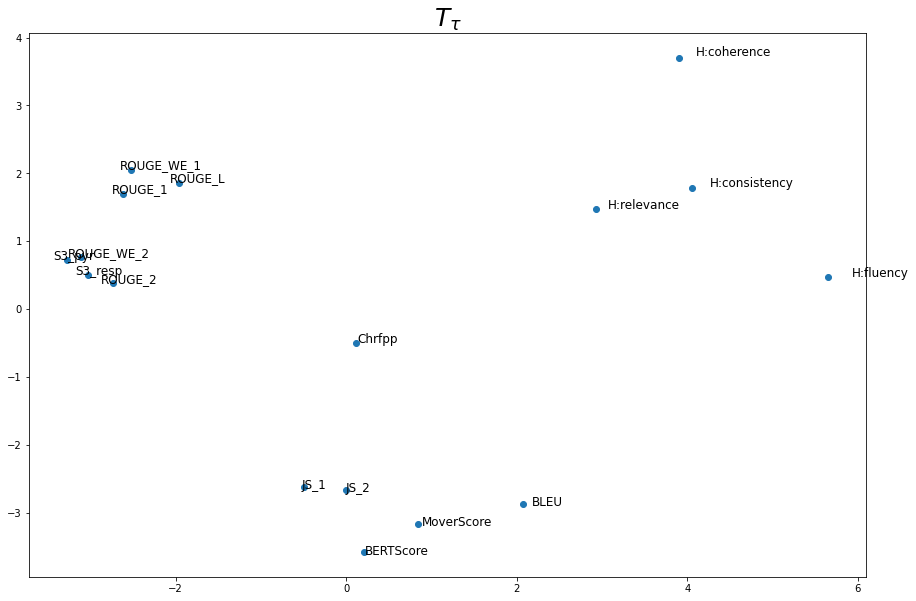

142.46506484284438 before
88.68793725543239 adfter
Starting with 17 nodes.
Aggregation 1 completed with 3 clusters and  0.2697182595729828 increment.
Aggregation 2 completed with 3 clusters and  0.0 increment.
$S_\tau$
-0.9195542847778825
-0.376100610077198
1.8984281694576712
4.58590034878671
6.189528994417738
6.584604579955271
4.558448859475119
-1.2268970279351625
-2.260957084193991
-0.8943121297234624
-2.2121199198398465
-2.854129041527686
-2.392489415885593
-2.1933248397737257
-2.2719830978442346
-3.0705302699591415
-3.144513230554584


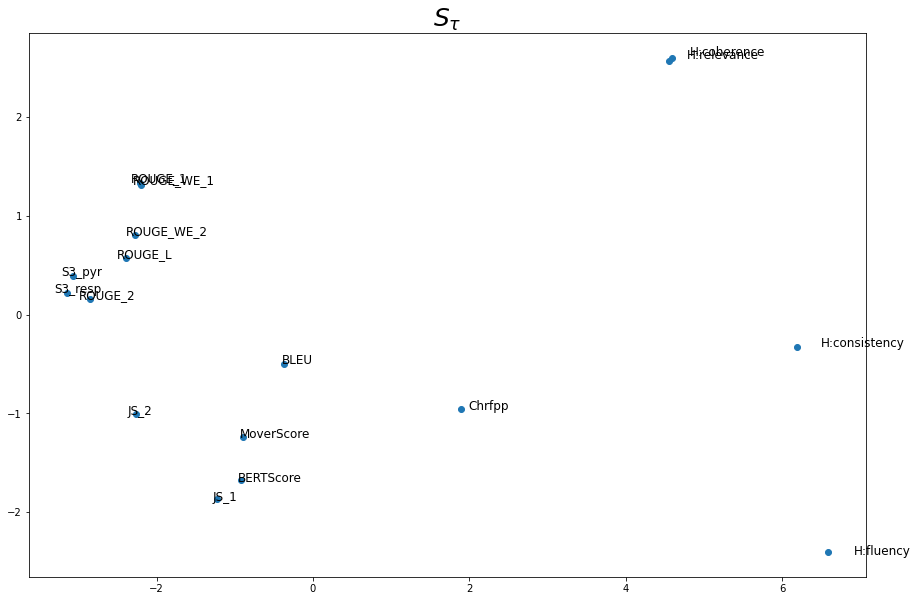

110.43833709552356 before
72.97121371430454 adfter
Starting with 17 nodes.
Aggregation 1 completed with 6 clusters and  0.167710542678833 increment.
Aggregation 2 completed with 6 clusters and  0.0 increment.
$T_\tau$
0.20566514352329412
2.0690276771447733
0.11960535379910052
3.904337750392469
4.056430265561938
5.649320856865572
2.92640452290053
-0.49400813865640225
-0.008984465879854004
0.8456945763143714
-2.6239311122447013
-2.73568700729998
-1.9662995678898065
-2.5257326963776436
-3.113561811270984
-3.27570921643631
-3.032572130446368


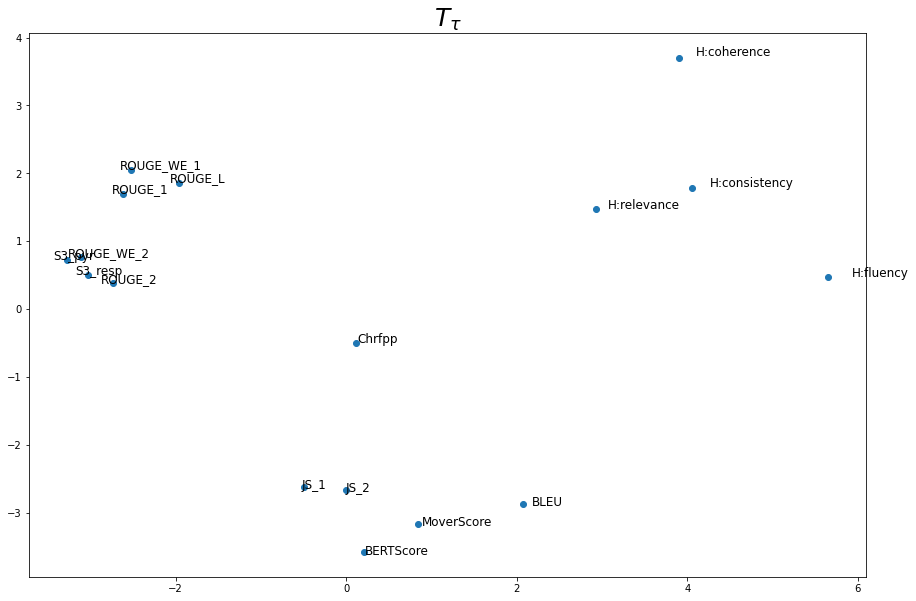

142.46506484284438 before
Starting with 17 nodes.
Aggregation 1 completed with 3 clusters and  0.09250041097402573 increment.
Aggregation 2 completed with 3 clusters and  0.0 increment.
$S_\tau$
-0.9195542847778825
-0.376100610077198
1.8984281694576712
4.58590034878671
6.189528994417738
6.584604579955271
4.558448859475119
-1.2268970279351625
-2.260957084193991
-0.8943121297234624
-2.2121199198398465
-2.854129041527686
-2.392489415885593
-2.1933248397737257
-2.2719830978442346
-3.0705302699591415
-3.144513230554584


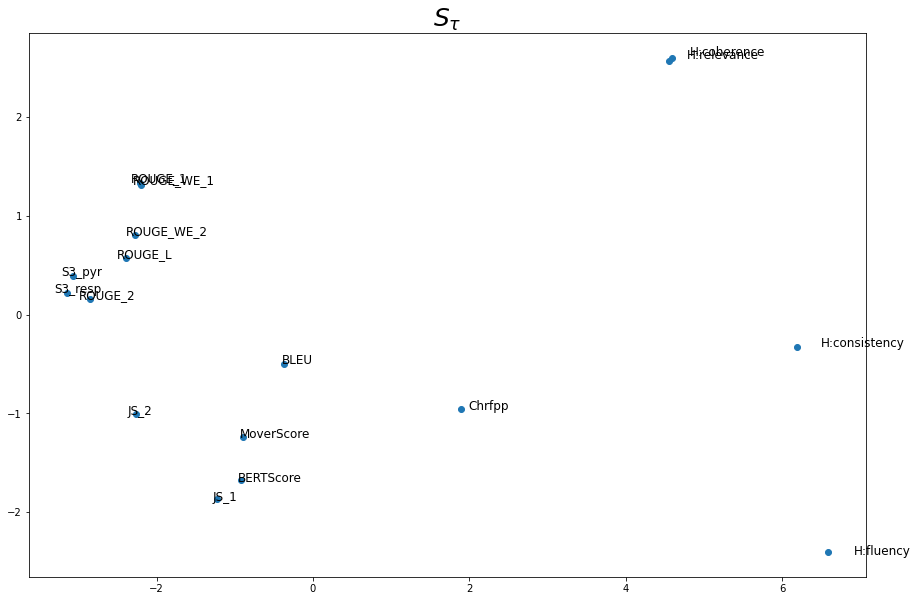

110.43833709552356 before
Starting with 17 nodes.
Aggregation 1 completed with 4 clusters and  0.1035892590880394 increment.
Aggregation 2 completed with 2 clusters and  0.010636508464813232 increment.
Aggregation 3 completed with 2 clusters and  0.0 increment.


/Users/colombo/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/colombo/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/stats.py:4484: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/colombo/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/stats.py:4053: PearsonRNearConstantInputWarning: An input array is nearly constant; the computed correlation coefficient may be inaccurate.
  warnings.warn(PearsonRNearConstantInputWarning())


$T_\tau$
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


/Users/colombo/opt/anaconda3/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:470: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var


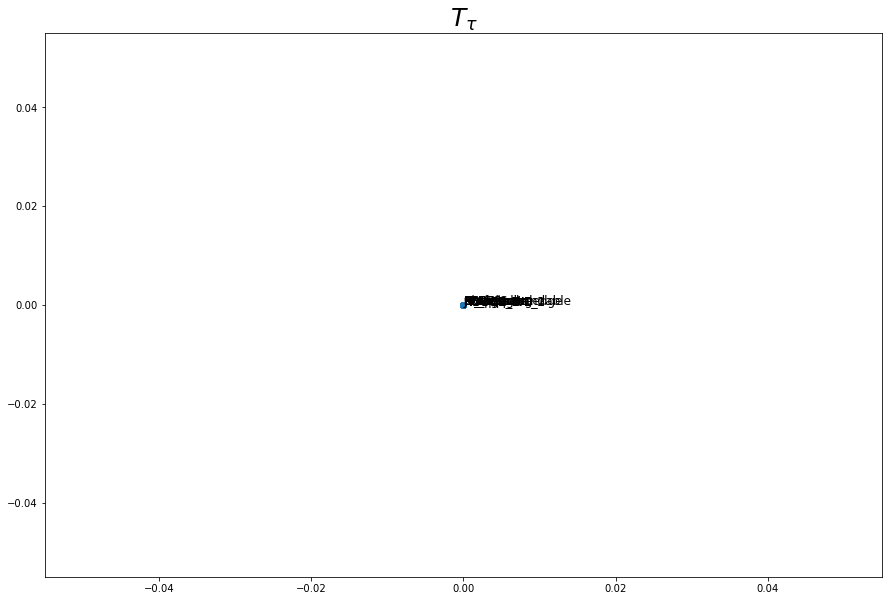

0 before
0 adfter
Error 
$S_\tau$
-1.240223782093294
-1.3781007711331712
-2.5491936460242584
4.476034431222942
4.228245138205459
4.938745356429599
5.344663542372746
4.853879274229322
3.9370894431623227
-1.252144573091379
-0.25811684436727395
-0.7401107656641794
-3.276386522377813
-2.5128046004316134
-2.9223458544771392
-3.0479086229809518
-1.5505518377148315
-3.5556734926835833
-3.4950958725829016


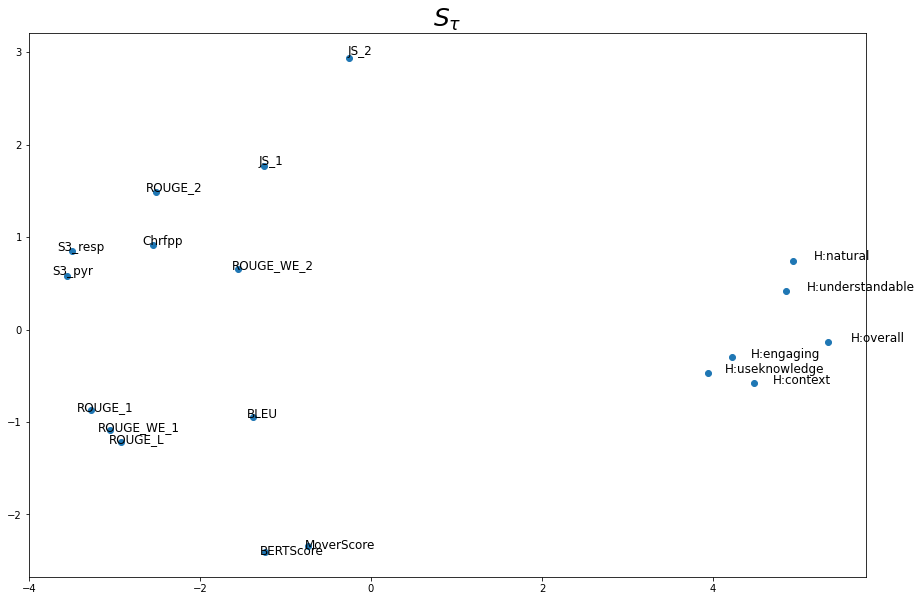

83.69307097157481 before
34.86275673414216 adfter
Starting with 19 nodes.
Aggregation 1 completed with 8 clusters and  0.36098167300224304 increment.
Aggregation 2 completed with 6 clusters and  0.04863567650318146 increment.
Aggregation 3 completed with 6 clusters and  0.0 increment.
$T_\tau$
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


/Users/colombo/opt/anaconda3/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:470: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var


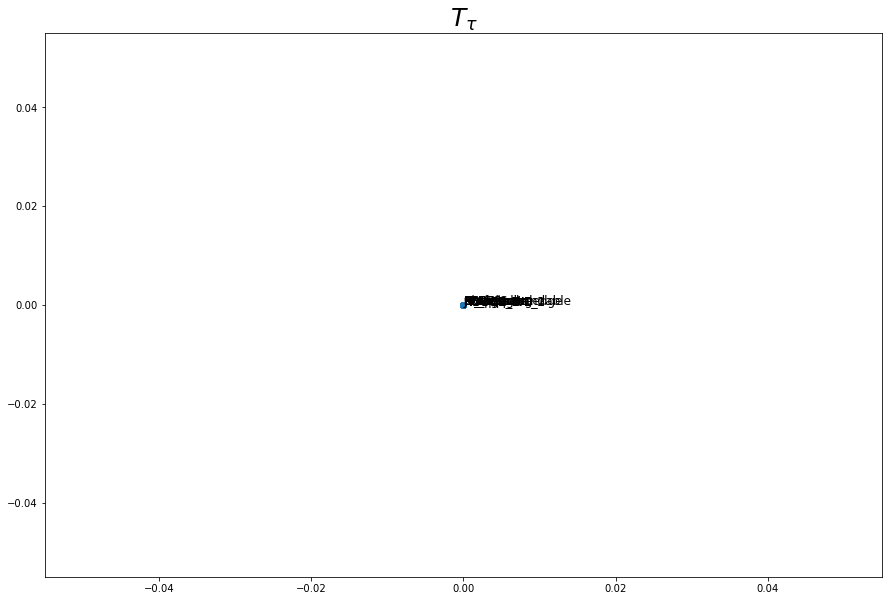

0 before
Error 
$S_\tau$
-1.240223782093294
-1.3781007711331712
-2.5491936460242584
4.476034431222942
4.228245138205459
4.938745356429599
5.344663542372746
4.853879274229322
3.9370894431623227
-1.252144573091379
-0.25811684436727395
-0.7401107656641794
-3.276386522377813
-2.5128046004316134
-2.9223458544771392
-3.0479086229809518
-1.5505518377148315
-3.5556734926835833
-3.4950958725829016


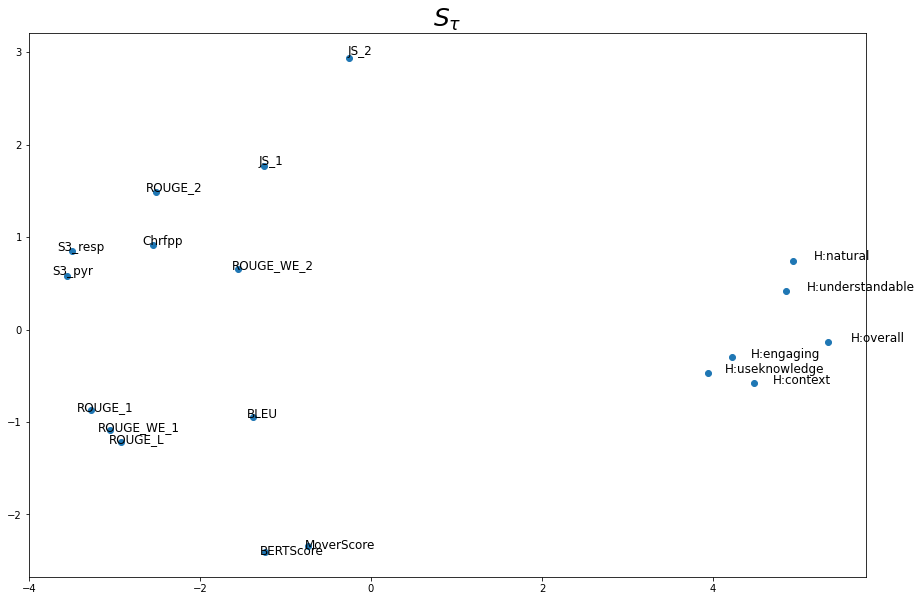

83.69307097157481 before
Starting with 19 nodes.
Aggregation 1 completed with 4 clusters and  0.19397993385791779 increment.
Aggregation 2 completed with 2 clusters and  0.016096793115139008 increment.
Aggregation 3 completed with 2 clusters and  0.0 increment.


/Users/colombo/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/colombo/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/stats.py:4484: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/colombo/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/stats.py:4053: PearsonRNearConstantInputWarning: An input array is nearly constant; the computed correlation coefficient may be inaccurate.
  warnings.warn(PearsonRNearConstantInputWarning())


$T_\tau$
-1.6000513486509162
-1.8891880199015199
-1.2626190820257435
1.8926092866859294
2.3317854935953837
2.5491573190224424
0.03560179150752316
7.533184062018083
0.2756744978505771
-1.284882798298085
-1.8432278418311012
-1.3589304924956709
-0.2695037200549954
-0.12162915524612086
-1.142392312777123
-0.36068459092567035
-0.1242477425017349
-1.256097674943238
-2.1045576710280205


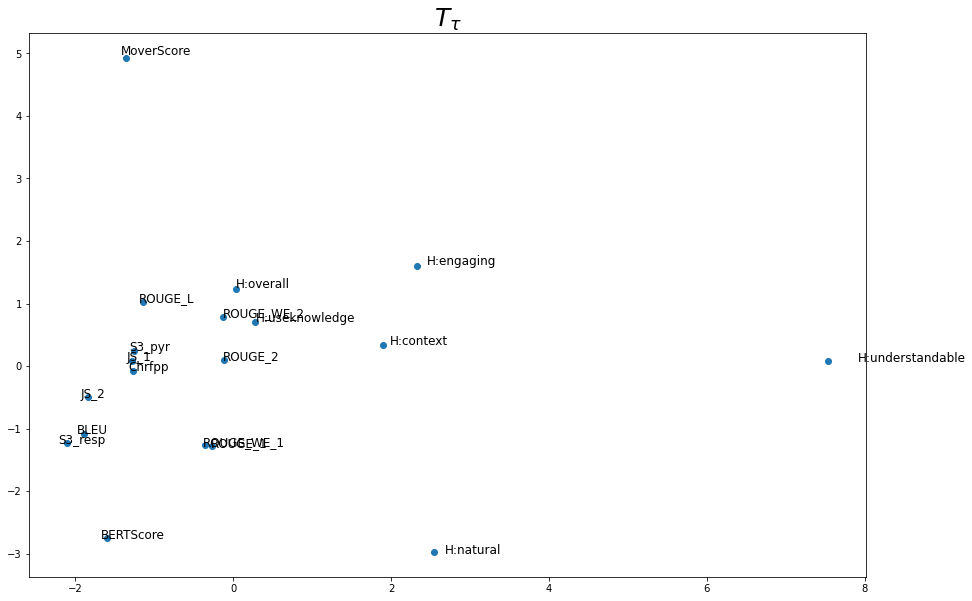

303.7509128529532 before
299.6901241195715 adfter
Starting with 19 nodes.
Aggregation 1 completed with 2 clusters and  0.050199586898088455 increment.
Aggregation 2 completed with 2 clusters and  0.0 increment.
$S_\tau$
-1.6345567886839987
-2.4910684131469782
-2.4614100973107136
4.863074608573162
4.601738895519332
6.670234897703758
5.006386476882733
6.198009397371435
5.446574847339703
-2.269442873898043
-2.2795678004324356
-1.8930137191565313
-2.634266695184961
-2.9555341260087515
-2.3197257998177823
-2.368351521703281
-2.7886413706832798
-3.366283189570777
-3.3241567277925927


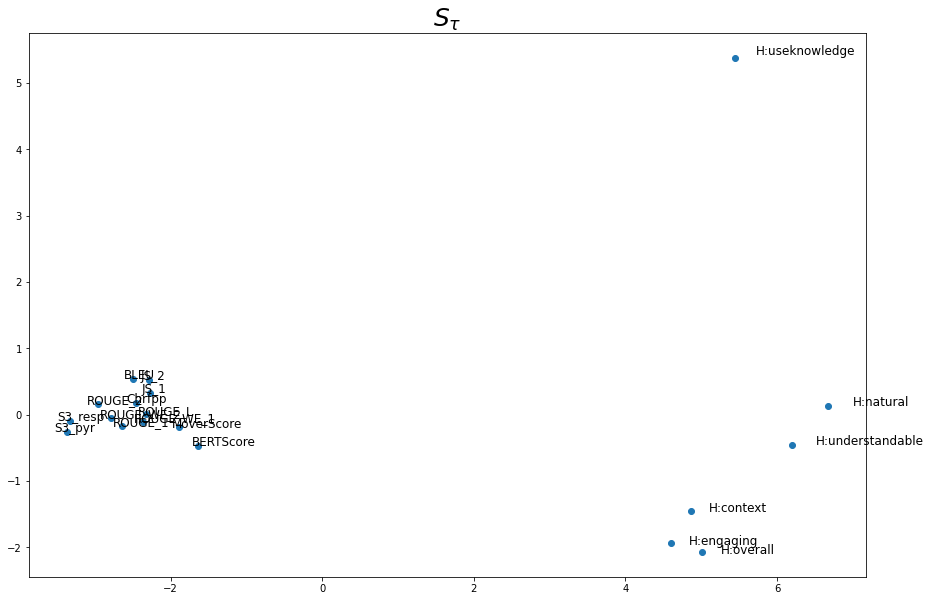

145.59625034405875 before
115.65781701596138 adfter
Starting with 19 nodes.
Aggregation 1 completed with 4 clusters and  0.13068383932113647 increment.
Aggregation 2 completed with 3 clusters and  0.008025847375392914 increment.
Aggregation 3 completed with 3 clusters and  0.0 increment.
$T_\tau$
-1.6000513486509162
-1.8891880199015199
-1.2626190820257435
1.8926092866859294
2.3317854935953837
2.5491573190224424
0.03560179150752316
7.533184062018083
0.2756744978505771
-1.284882798298085
-1.8432278418311012
-1.3589304924956709
-0.2695037200549954
-0.12162915524612086
-1.142392312777123
-0.36068459092567035
-0.1242477425017349
-1.256097674943238
-2.1045576710280205


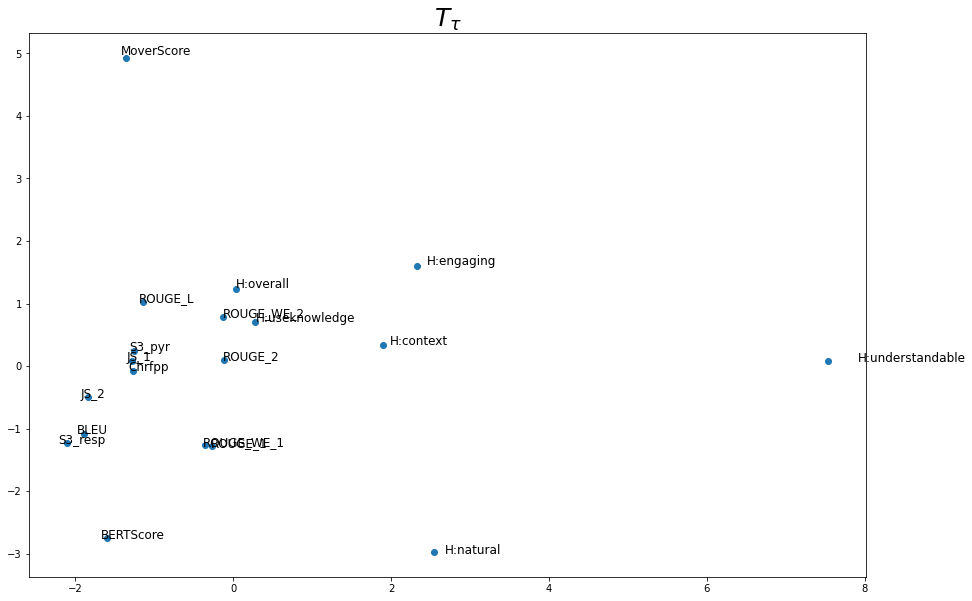

303.7509128529532 before
Starting with 19 nodes.
Aggregation 1 completed with 2 clusters and  0.04402802884578705 increment.
Aggregation 2 completed with 2 clusters and  0.0 increment.
$S_\tau$
-1.6345567886839987
-2.4910684131469782
-2.4614100973107136
4.863074608573162
4.601738895519332
6.670234897703758
5.006386476882733
6.198009397371435
5.446574847339703
-2.269442873898043
-2.2795678004324356
-1.8930137191565313
-2.634266695184961
-2.9555341260087515
-2.3197257998177823
-2.368351521703281
-2.7886413706832798
-3.366283189570777
-3.3241567277925927


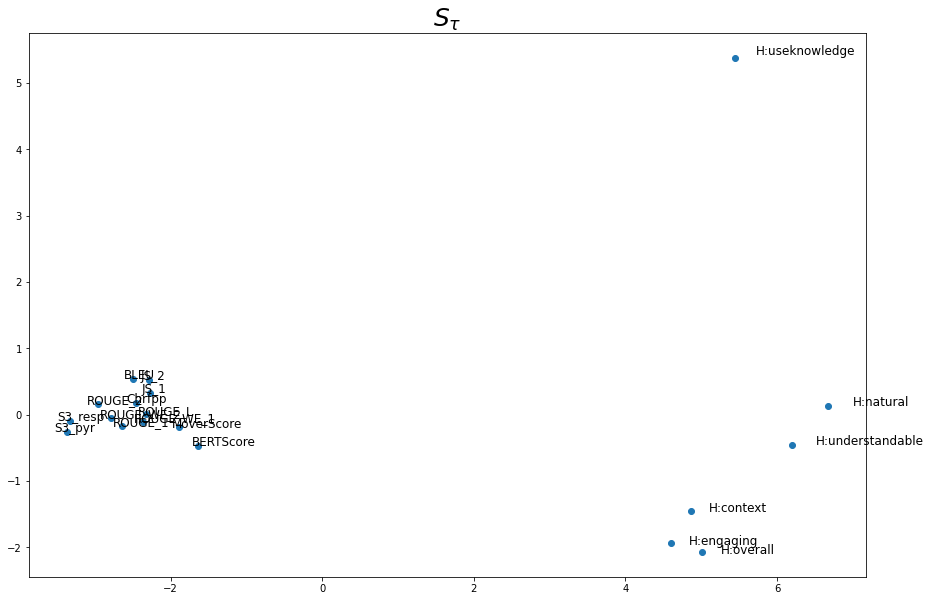

145.59625034405875 before
Starting with 19 nodes.
Aggregation 1 completed with 2 clusters and  0.14368179440498352 increment.
Aggregation 2 completed with 2 clusters and  0.0 increment.


/Users/colombo/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/colombo/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/stats.py:4484: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/colombo/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/stats.py:4053: PearsonRNearConstantInputWarning: An input array is nearly constant; the computed correlation coefficient may be inaccurate.
  warnings.warn(PearsonRNearConstantInputWarning())


$T_\tau$
4.903682716725496
2.9819260441003994
-0.349541390605847
1.0684869240900232
-0.7951704269369945
-0.08835554697352913
3.7598771448285193
-2.203998039441127
-1.0737498384190447
-2.446149168637135
-2.131633358736622
-0.3739524365081764
-1.5653667931658135
-1.6860558303201465


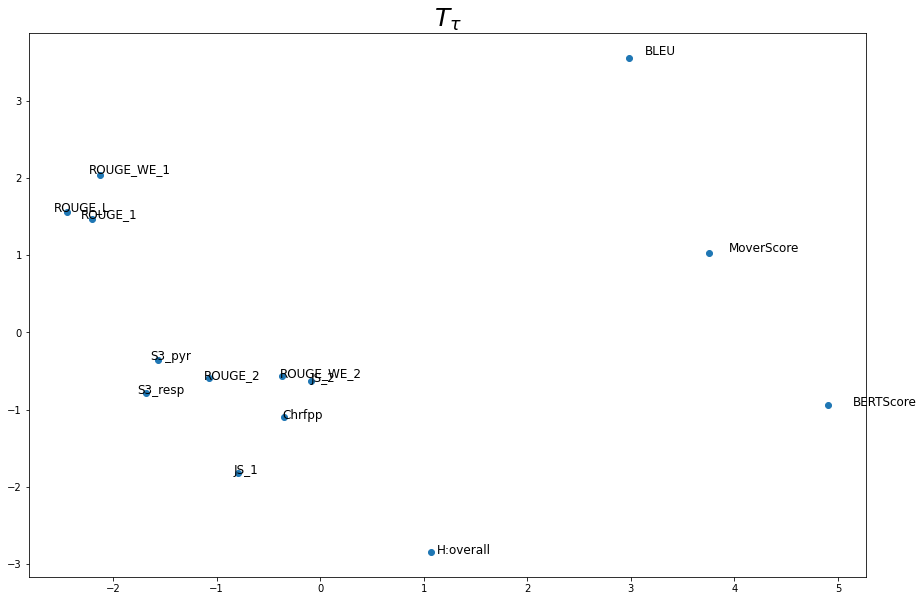

136.645975558405 before
132.80967722869977 adfter
Starting with 14 nodes.
Aggregation 1 completed with 3 clusters and  0.03214387968182564 increment.
Aggregation 2 completed with 3 clusters and  0.0 increment.
$S_\tau$
1.1377224217527497
1.9553717322825965
3.2830323204463836
2.872803481956837
1.6604365552243785
1.5299854352354119
1.3792676343805432
-3.03851310091916
0.16201275323874192
-2.890534166271223
-2.934477402857678
-1.8515639548130474
-2.2110143534419224
-1.0545293562146125


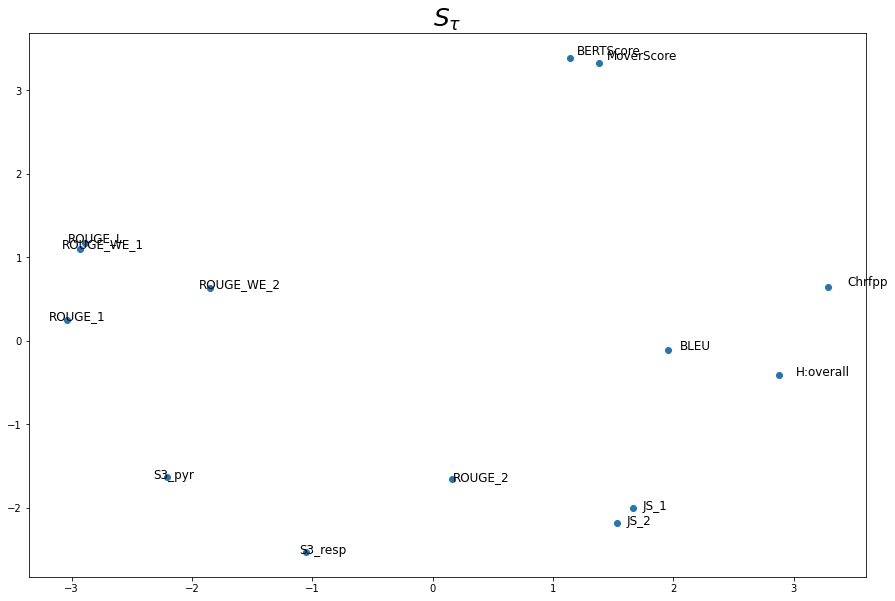

73.90072620437405 before
30.296504864919925 adfter
Starting with 14 nodes.
Aggregation 1 completed with 6 clusters and  0.2543494999408722 increment.
Aggregation 2 completed with 6 clusters and  0.0 increment.
$T_\tau$
4.903682716725496
2.9819260441003994
-0.349541390605847
1.0684869240900232
-0.7951704269369945
-0.08835554697352913
3.7598771448285193
-2.203998039441127
-1.0737498384190447
-2.446149168637135
-2.131633358736622
-0.3739524365081764
-1.5653667931658135
-1.6860558303201465


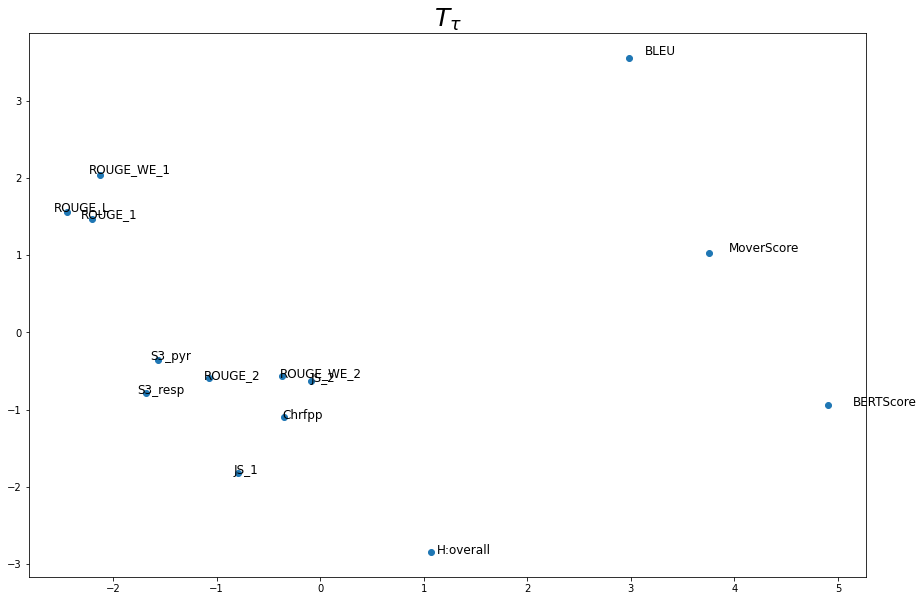

136.645975558405 before
Starting with 14 nodes.
Aggregation 1 completed with 3 clusters and  0.022227555513381958 increment.
Aggregation 2 completed with 3 clusters and  0.0 increment.
$S_\tau$
1.1377224217527497
1.9553717322825965
3.2830323204463836
2.872803481956837
1.6604365552243785
1.5299854352354119
1.3792676343805432
-3.03851310091916
0.16201275323874192
-2.890534166271223
-2.934477402857678
-1.8515639548130474
-2.2110143534419224
-1.0545293562146125


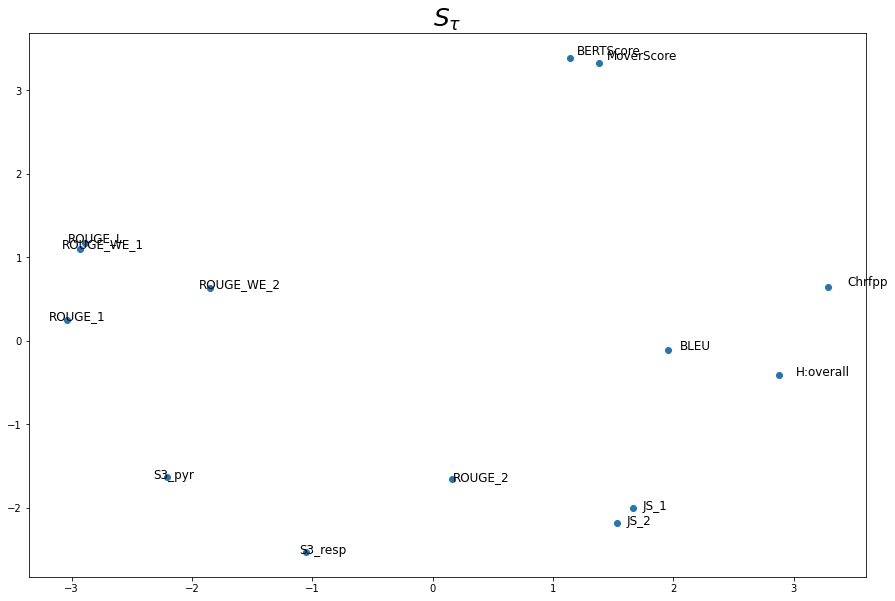

73.90072620437405 before
Starting with 14 nodes.
Aggregation 1 completed with 4 clusters and  0.07898540049791336 increment.
Aggregation 2 completed with 3 clusters and  0.01202365756034851 increment.
Aggregation 3 completed with 3 clusters and  0.0 increment.
$T_\tau$
-0.01497716515472765
-1.4261919890201449
-1.0922462471737655
1.8598519199388528
-0.22452240205132645
-1.3002004404454715
-1.6603007270653038
6.815467106270486
-1.4784400276492988
-1.4784400276492988


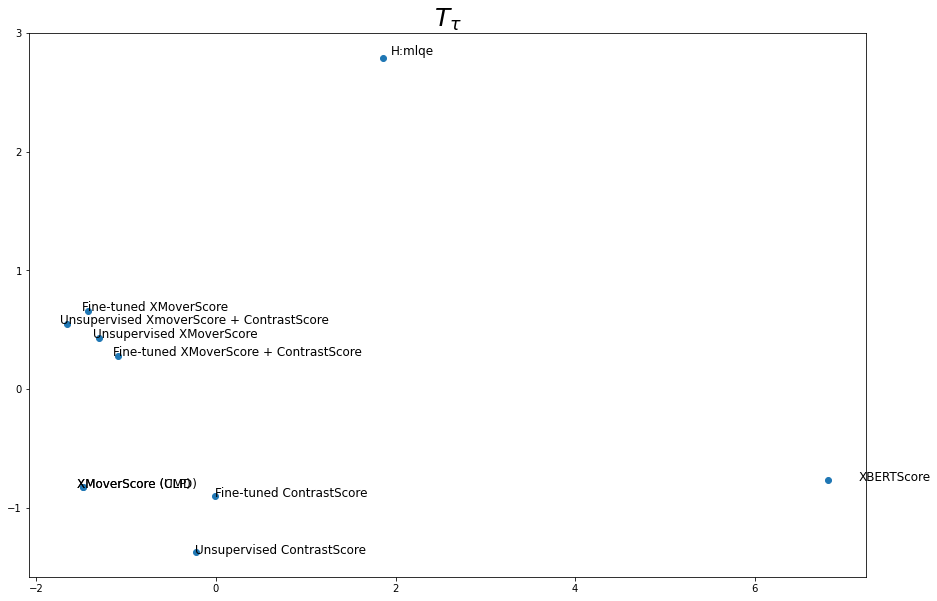

63.2261792399662 before
59.01096988791475 adfter
Starting with 10 nodes.
Aggregation 1 completed with 2 clusters and  0.11530586332082748 increment.
Aggregation 2 completed with 2 clusters and  0.0 increment.
$S_\tau$
2.9010242542969817
-1.8403400232004474
-1.4145507975325753
3.1537012871058163
2.8448858882731125
-2.062784373560087
-1.4760179950504069
2.193913891870355
-2.1499160661013743
-2.1499160661013743


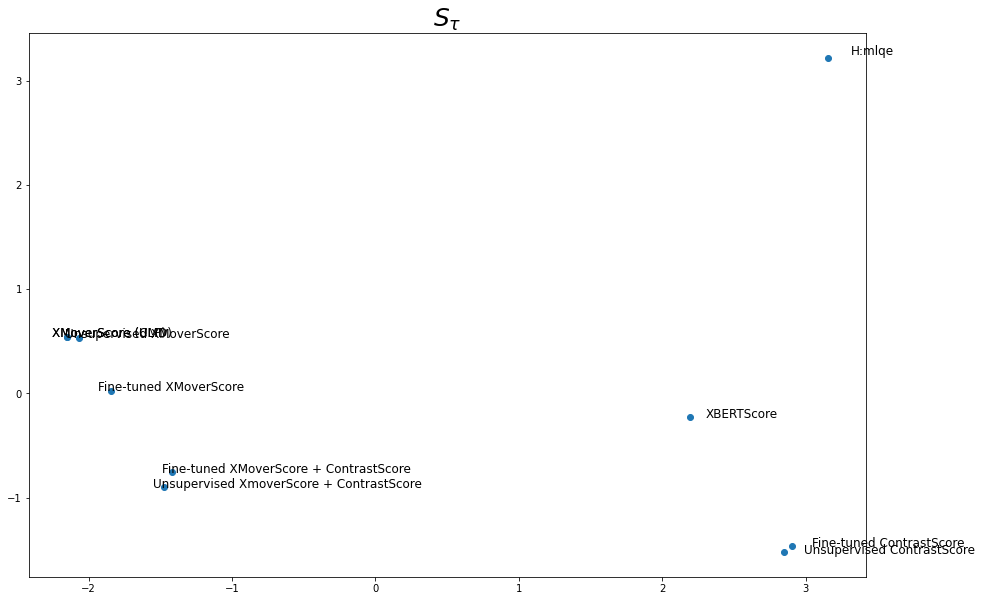

38.62852452452452 before
20.871535535535536 adfter
Starting with 10 nodes.
Aggregation 1 completed with 4 clusters and  0.2409391701221466 increment.
Aggregation 2 completed with 4 clusters and  0.0 increment.
$T_\tau$
-0.01497716515472765
-1.4261919890201449
-1.0922462471737655
1.8598519199388528
-0.22452240205132645
-1.3002004404454715
-1.6603007270653038
6.815467106270486
-1.4784400276492988
-1.4784400276492988


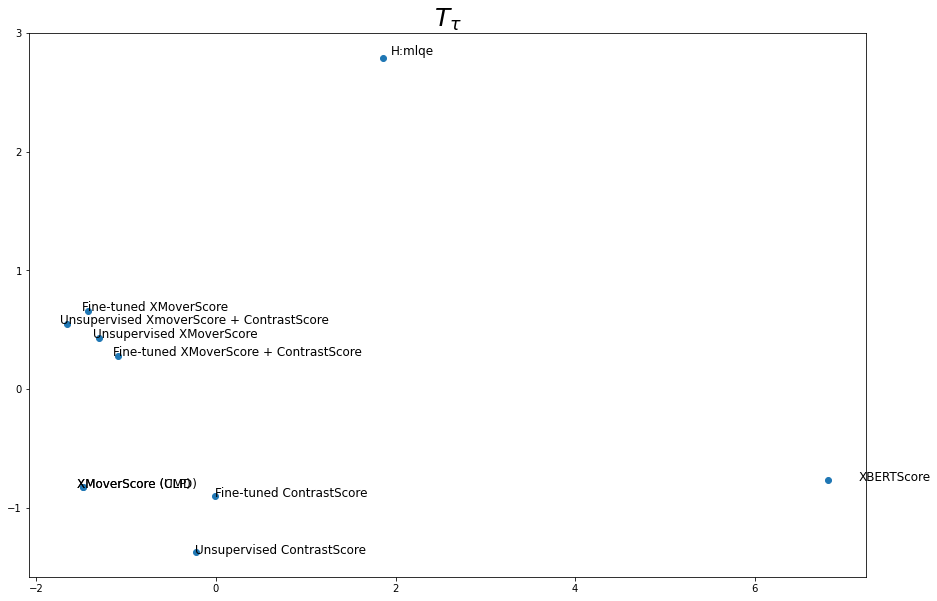

63.2261792399662 before
Starting with 10 nodes.
Aggregation 1 completed with 2 clusters and  0.08348945528268814 increment.
$S_\tau$
2.9010242542969817
-1.8403400232004474
-1.4145507975325753
3.1537012871058163
2.8448858882731125
-2.062784373560087
-1.4760179950504069
2.193913891870355
-2.1499160661013743
-2.1499160661013743


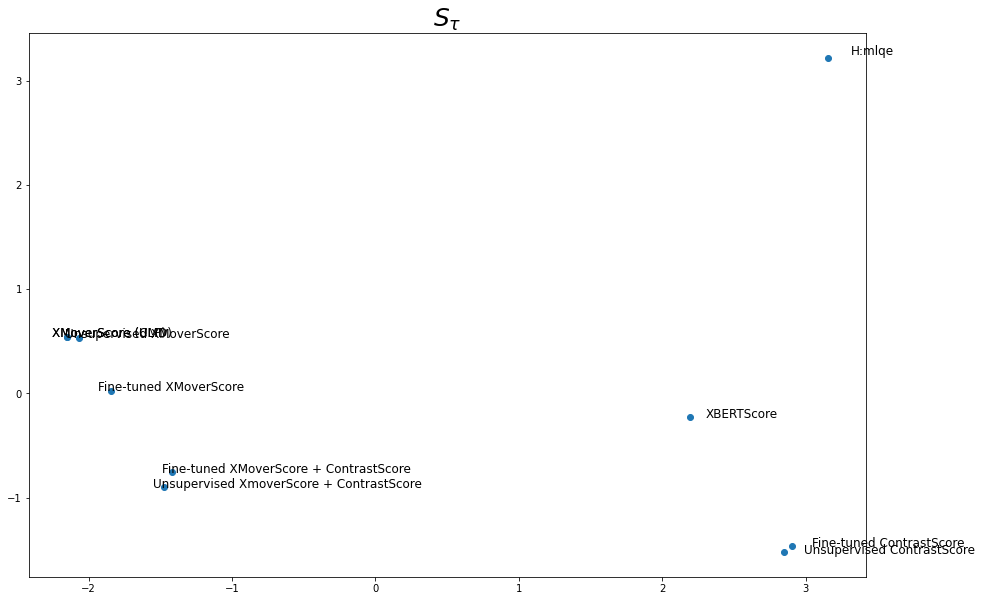

38.62852452452452 before
Starting with 10 nodes.
Aggregation 1 completed with 3 clusters and  0.09430581331253052 increment.
Aggregation 2 completed with 2 clusters and  0.03179483860731125 increment.
Aggregation 3 completed with 2 clusters and  0.0 increment.
$T_\tau$
2.828366891162452
-0.6865229257155172
-2.261352606694364
1.8637889141493766
-0.14456837892330615
-1.0976663855229745
-1.0436347615380517
-3.335155643220215
4.604315081811009
-0.5749982800328414
-1.7950899078372295
2.0655253424794524
-1.055144865049241
-3.1419504816172075
3.7740880065486597


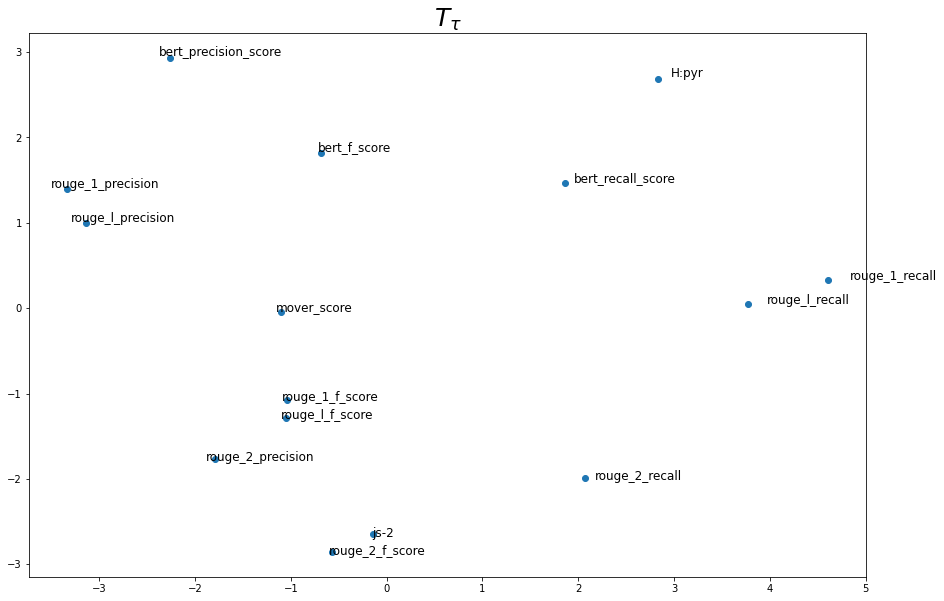

110.63939324711228 before
81.1899621902221 adfter
Starting with 15 nodes.
Aggregation 1 completed with 3 clusters and  0.18281374871730804 increment.
Aggregation 2 completed with 3 clusters and  0.0 increment.
$S_\tau$
4.850000331515133
-2.0145843263025927
-2.1796004149673034
-0.06604340661883162
1.087770896666202
-1.353130215180988
-1.8469499966476357
-2.6327247542060324
3.1165676269995854
0.5402435763841404
-0.4352577994785591
2.3797670142721805
-1.5355729410543502
-2.7196869597596987
2.8092013683787505


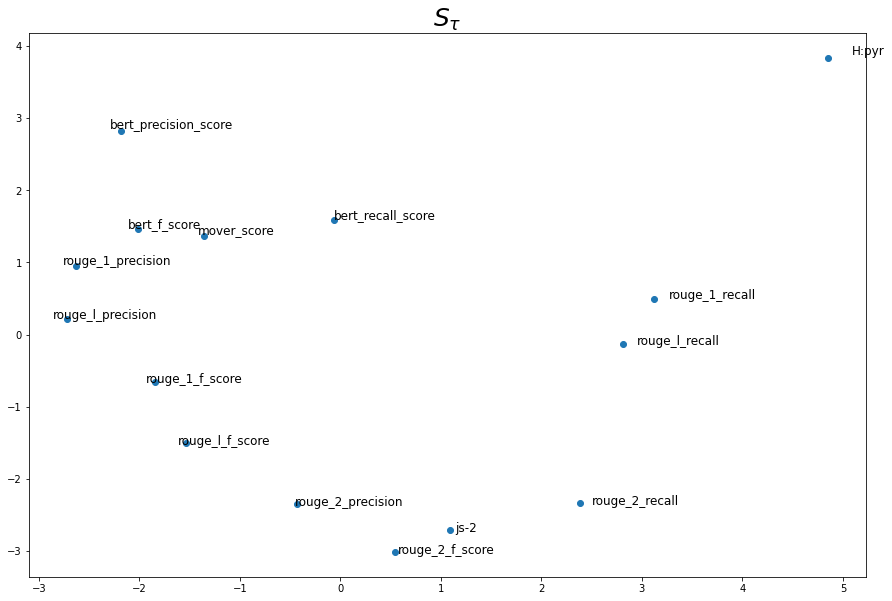

129.90753217879237 before
110.16646464646468 adfter
Starting with 15 nodes.
Aggregation 1 completed with 3 clusters and  0.11015043407678604 increment.
Aggregation 2 completed with 3 clusters and  0.0 increment.
$T_\tau$
2.828366891162452
-0.6865229257155172
-2.261352606694364
1.8637889141493766
-0.14456837892330615
-1.0976663855229745
-1.0436347615380517
-3.335155643220215
4.604315081811009
-0.5749982800328414
-1.7950899078372295
2.0655253424794524
-1.055144865049241
-3.1419504816172075
3.7740880065486597


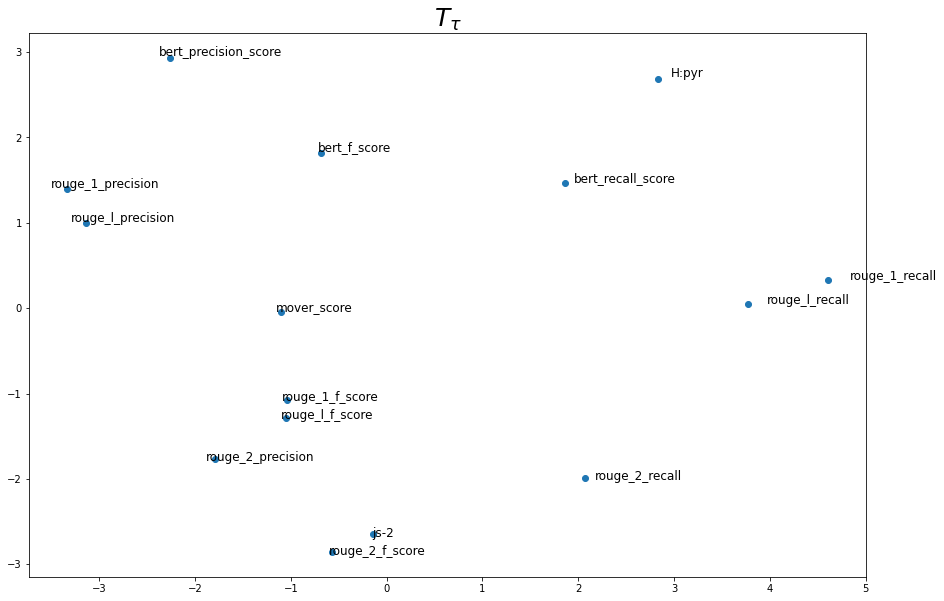

110.63939324711228 before
Starting with 15 nodes.
Aggregation 1 completed with 2 clusters and  0.08760415762662888 increment.
Aggregation 2 completed with 2 clusters and  0.0 increment.
$S_\tau$
4.850000331515133
-2.0145843263025927
-2.1796004149673034
-0.06604340661883162
1.087770896666202
-1.353130215180988
-1.8469499966476357
-2.6327247542060324
3.1165676269995854
0.5402435763841404
-0.4352577994785591
2.3797670142721805
-1.5355729410543502
-2.7196869597596987
2.8092013683787505


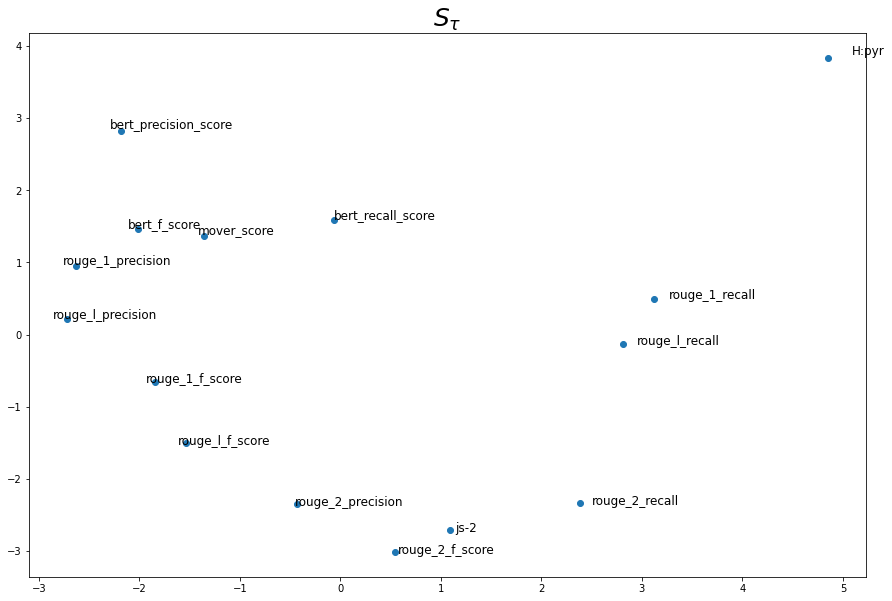

129.90753217879237 before
Starting with 15 nodes.
Aggregation 1 completed with 3 clusters and  0.0677880048751831 increment.
Aggregation 2 completed with 2 clusters and  0.005507171154022217 increment.
Aggregation 3 completed with 2 clusters and  0.0 increment.


/Users/colombo/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/colombo/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/stats.py:4484: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


$T_\tau$
0.20566514352329412
2.0690276771447733
0.11960535379910052
3.904337750392469
4.056430265561938
5.649320856865572
2.92640452290053
-0.49400813865640225
-0.008984465879854004
0.8456945763143714
-2.6239311122447013
-2.73568700729998
-1.9662995678898065
-2.5257326963776436
-3.113561811270984
-3.27570921643631
-3.032572130446368


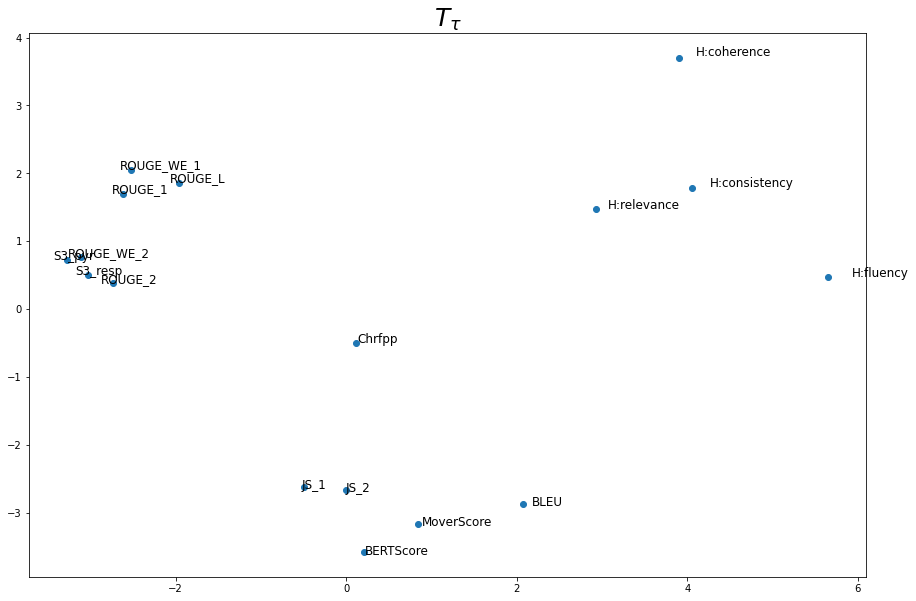

142.46506484284438 before
88.68793725543239 adfter
Starting with 17 nodes.
Aggregation 1 completed with 3 clusters and  0.2697182595729828 increment.
Aggregation 2 completed with 3 clusters and  0.0 increment.
$S_\tau$
-0.9195542847778825
-0.376100610077198
1.8984281694576712
4.58590034878671
6.189528994417738
6.584604579955271
4.558448859475119
-1.2268970279351625
-2.260957084193991
-0.8943121297234624
-2.2121199198398465
-2.854129041527686
-2.392489415885593
-2.1933248397737257
-2.2719830978442346
-3.0705302699591415
-3.144513230554584


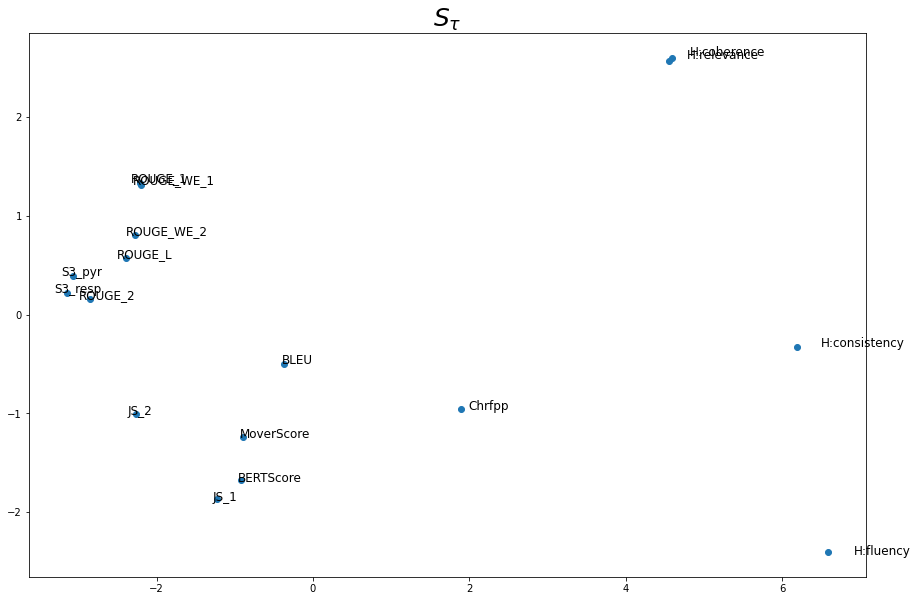

110.43833709552356 before
72.97121371430454 adfter
Starting with 17 nodes.
Aggregation 1 completed with 6 clusters and  0.167710542678833 increment.
Aggregation 2 completed with 6 clusters and  0.0 increment.
$T_\tau$
0.20566514352329412
2.0690276771447733
0.11960535379910052
3.904337750392469
4.056430265561938
5.649320856865572
2.92640452290053
-0.49400813865640225
-0.008984465879854004
0.8456945763143714
-2.6239311122447013
-2.73568700729998
-1.9662995678898065
-2.5257326963776436
-3.113561811270984
-3.27570921643631
-3.032572130446368


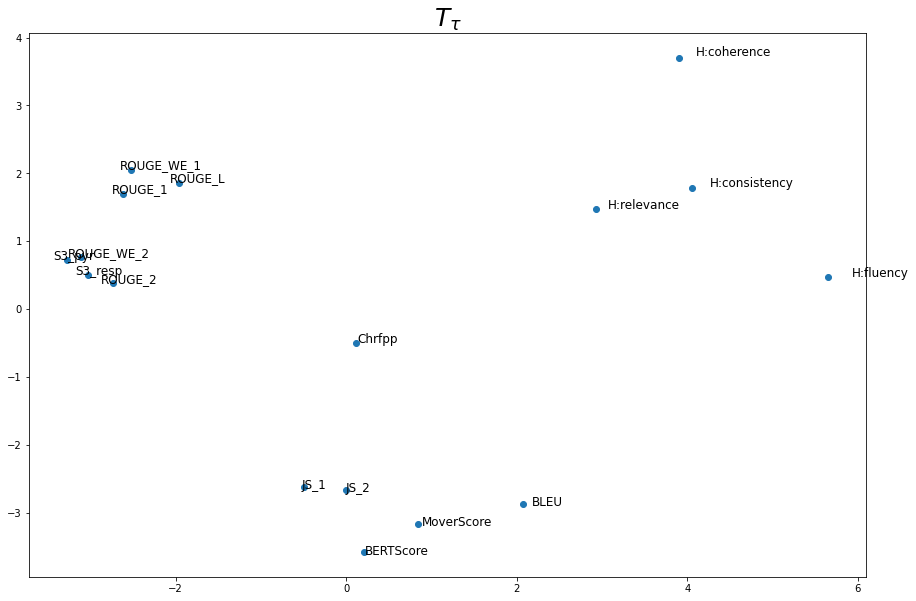

142.46506484284438 before
Starting with 17 nodes.
Aggregation 1 completed with 3 clusters and  0.09250041097402573 increment.
Aggregation 2 completed with 3 clusters and  0.0 increment.
$S_\tau$
-0.9195542847778825
-0.376100610077198
1.8984281694576712
4.58590034878671
6.189528994417738
6.584604579955271
4.558448859475119
-1.2268970279351625
-2.260957084193991
-0.8943121297234624
-2.2121199198398465
-2.854129041527686
-2.392489415885593
-2.1933248397737257
-2.2719830978442346
-3.0705302699591415
-3.144513230554584


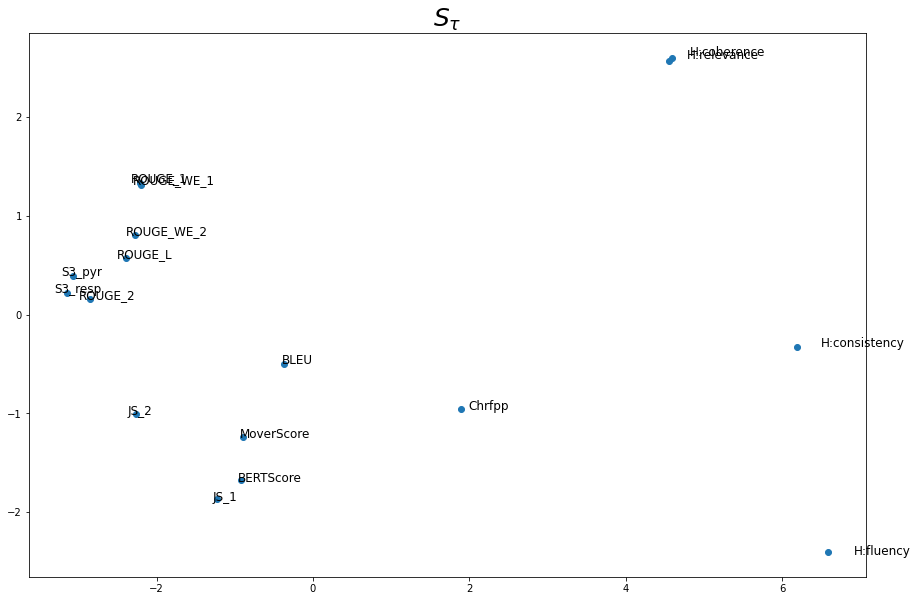

110.43833709552356 before
Starting with 17 nodes.
Aggregation 1 completed with 4 clusters and  0.1035892590880394 increment.
Aggregation 2 completed with 2 clusters and  0.010636508464813232 increment.
Aggregation 3 completed with 2 clusters and  0.0 increment.
$T_\tau$
-0.4737598653800422
1.2932081292710014
3.521929626889734
5.147794515071521
5.470218954376841
-1.4004944748030934
-0.9299814736682908
-0.29788007846326314
-1.8588708454210394
-1.7574768304867505
0.20902432494320689
-1.544734203861098
-1.4305257983363
-3.0208414131203116
-2.927610567012116


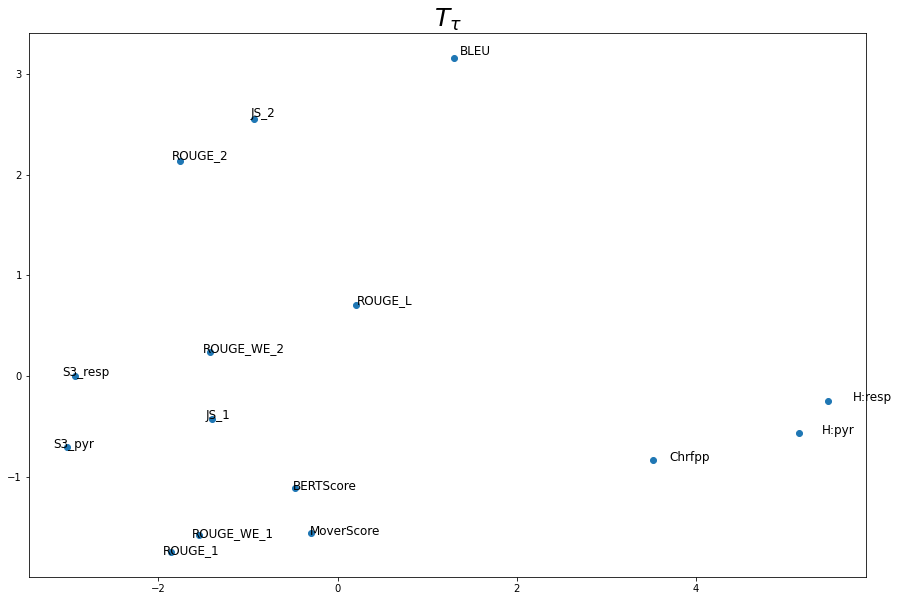

127.18369041682608 before
101.15409024400223 adfter
Starting with 15 nodes.
Aggregation 1 completed with 3 clusters and  0.09042256325483322 increment.
Aggregation 2 completed with 2 clusters and  0.005368739366531372 increment.
Aggregation 3 completed with 2 clusters and  0.0 increment.
$S_\tau$
1.2812527767325275
-0.1676616856487241
4.175942586484263
5.009220364965739
6.474975188911344
-0.23883209382221277
-1.64515353780617
-0.5104439308944942
-2.002843800007966
-1.8739971875921597
-2.0890663199592114
-1.5234988940259144
-1.5340035380404236
-2.7612272969637592
-2.594662632332839


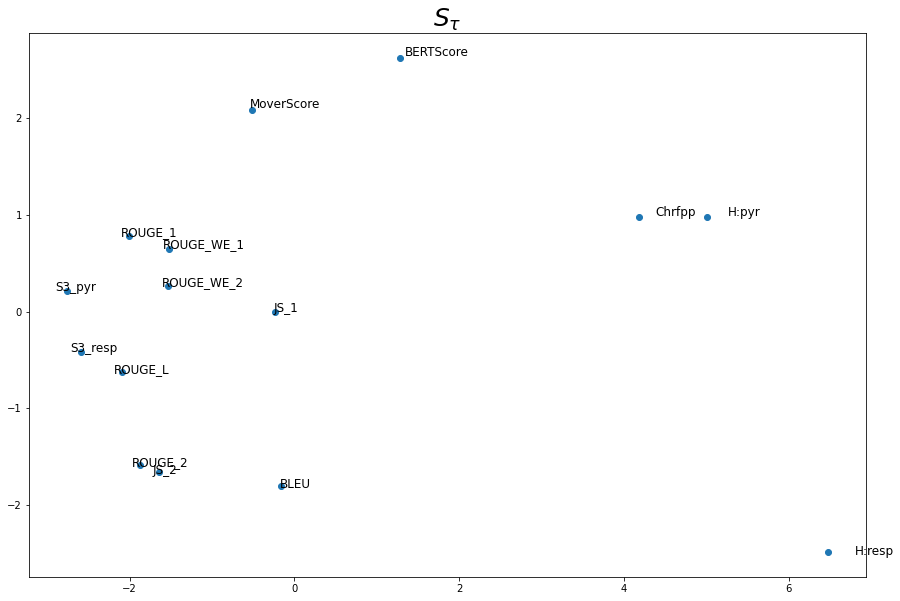

90.65710553512665 before
58.08510638297872 adfter
Starting with 15 nodes.
Aggregation 1 completed with 7 clusters and  0.1231890320777893 increment.
Aggregation 2 completed with 5 clusters and  0.028288135305047035 increment.
Aggregation 3 completed with 5 clusters and  0.0 increment.
$T_\tau$
-0.4737598653800422
1.2932081292710014
3.521929626889734
5.147794515071521
5.470218954376841
-1.4004944748030934
-0.9299814736682908
-0.29788007846326314
-1.8588708454210394
-1.7574768304867505
0.20902432494320689
-1.544734203861098
-1.4305257983363
-3.0208414131203116
-2.927610567012116


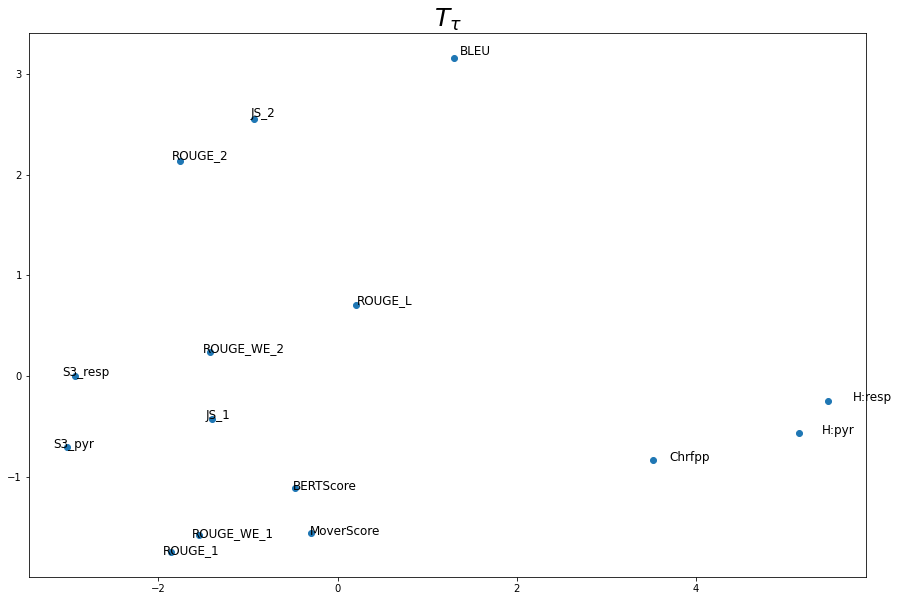

127.18369041682608 before
Starting with 15 nodes.
Aggregation 1 completed with 3 clusters and  0.05288001894950867 increment.
$S_\tau$
1.2812527767325275
-0.1676616856487241
4.175942586484263
5.009220364965739
6.474975188911344
-0.23883209382221277
-1.64515353780617
-0.5104439308944942
-2.002843800007966
-1.8739971875921597
-2.0890663199592114
-1.5234988940259144
-1.5340035380404236
-2.7612272969637592
-2.594662632332839


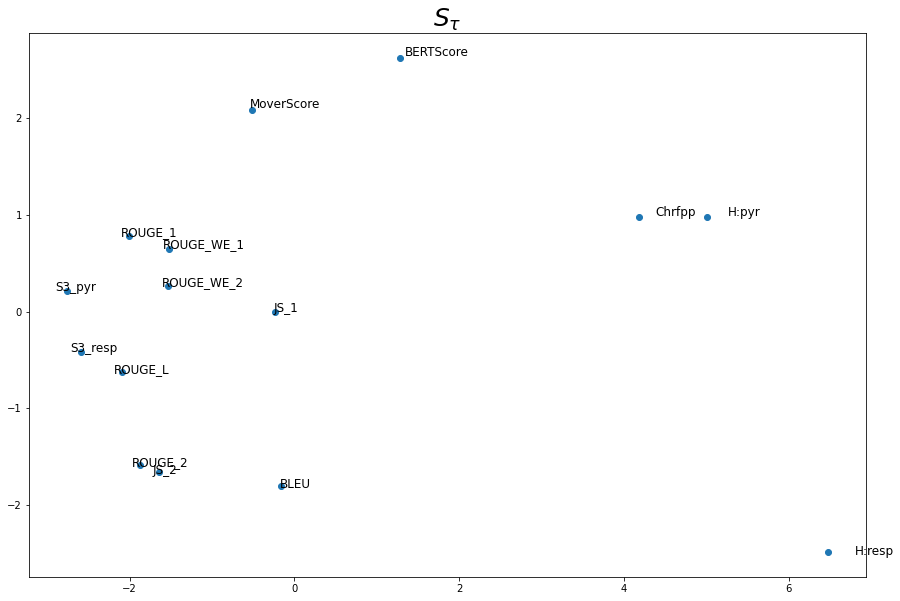

90.65710553512665 before
Starting with 15 nodes.
Aggregation 1 completed with 3 clusters and  0.06981486827135086 increment.
Aggregation 2 completed with 2 clusters and  0.005082577466964722 increment.
Aggregation 3 completed with 2 clusters and  0.0 increment.
$T_\tau$
-0.6932037997207907
0.9974656628111112
3.9068015661626787
4.310312437095723
6.490407890689073
-1.337986589023067
-1.0191616319564993
-0.5017479395166862
-1.6956027291433409
-1.921350558744079
0.293820528856663
-1.371891530532021
-1.5395495221866704
-2.9708313275521814
-2.9474824572399148


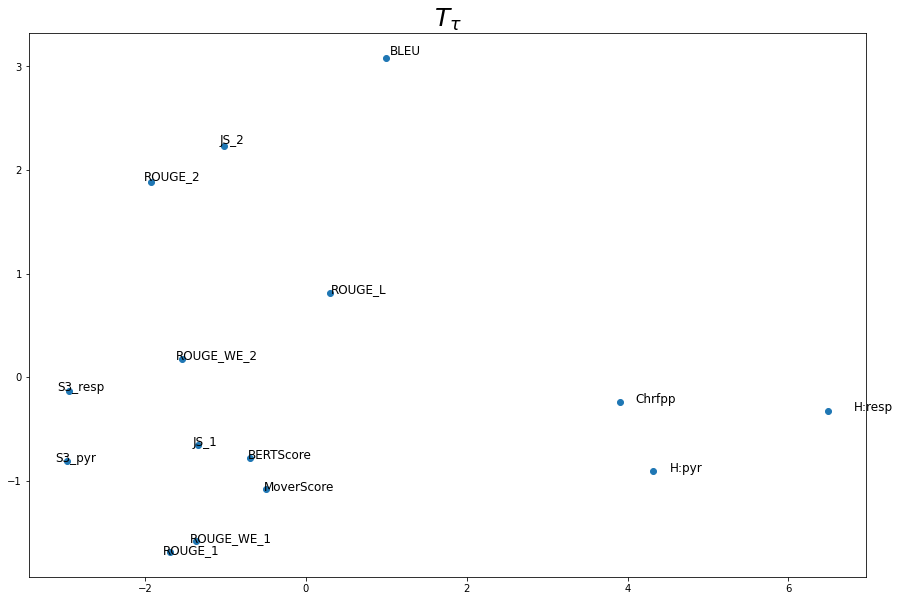

136.70666385840025 before
127.2137741322359 adfter
Starting with 15 nodes.
Aggregation 1 completed with 2 clusters and  0.08125529438257217 increment.
Aggregation 2 completed with 2 clusters and  0.0 increment.
$S_\tau$
1.689350589438706
0.2007267033457386
2.832430645317468
5.108256319854653
7.0522458369341585
-0.6405250711363706
-1.3046131616981773
0.7092502155577127
-2.285205015673732
-1.6586386206575892
-1.97543328542461
-2.3498576175720713
-1.6973441689913078
-2.820036673700465
-2.8606066955941145


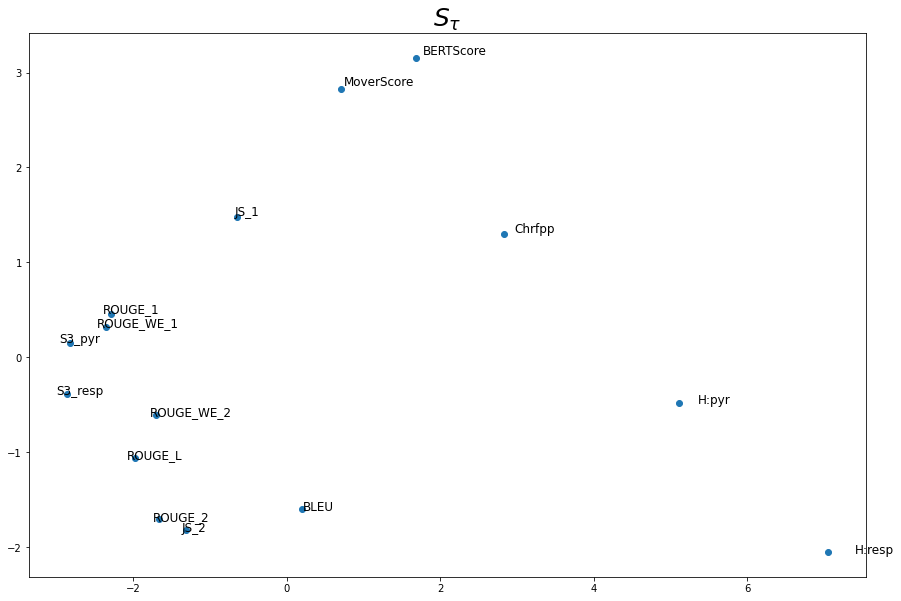

107.85538250661385 before
76.99154334038055 adfter
Starting with 15 nodes.
Aggregation 1 completed with 5 clusters and  0.135774627327919 increment.
Aggregation 2 completed with 5 clusters and  0.0 increment.
$T_\tau$
-0.6932037997207907
0.9974656628111112
3.9068015661626787
4.310312437095723
6.490407890689073
-1.337986589023067
-1.0191616319564993
-0.5017479395166862
-1.6956027291433409
-1.921350558744079
0.293820528856663
-1.371891530532021
-1.5395495221866704
-2.9708313275521814
-2.9474824572399148


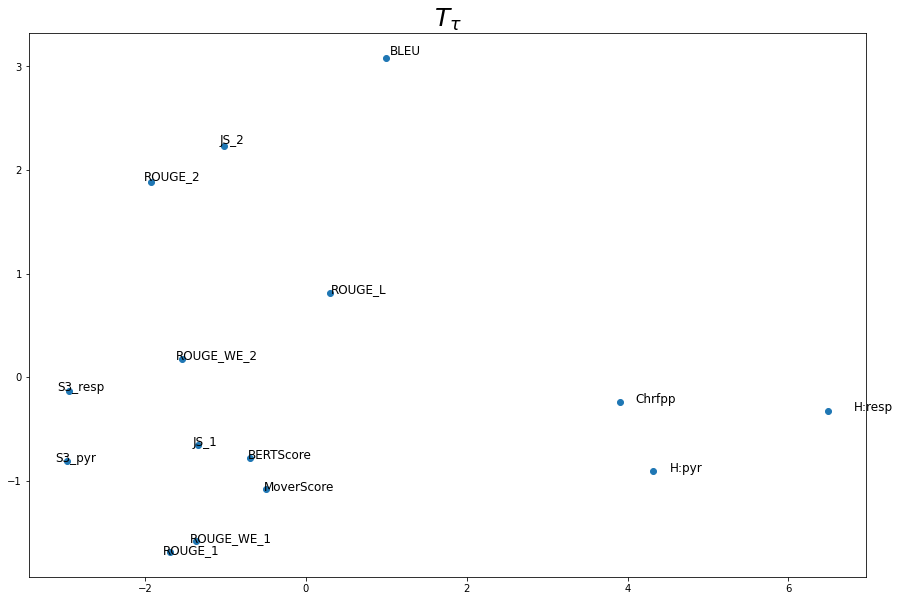

136.70666385840025 before
Starting with 15 nodes.
$S_\tau$
1.689350589438706
0.2007267033457386
2.832430645317468
5.108256319854653
7.0522458369341585
-0.6405250711363706
-1.3046131616981773
0.7092502155577127
-2.285205015673732
-1.6586386206575892
-1.97543328542461
-2.3498576175720713
-1.6973441689913078
-2.820036673700465
-2.8606066955941145


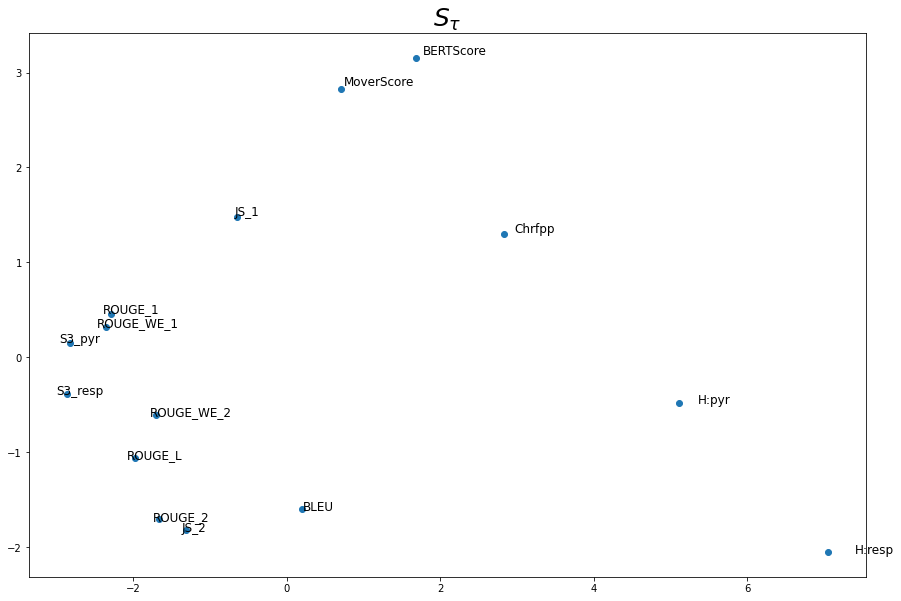

107.85538250661385 before
Starting with 15 nodes.
Aggregation 1 completed with 3 clusters and  0.06803862750530243 increment.
Aggregation 2 completed with 2 clusters and  0.009548872709274292 increment.
Aggregation 3 completed with 2 clusters and  0.0 increment.
$T_\tau$
-1.0781210944560495
0.20354960612677322
3.876907204870039
4.325115132409978
5.095877202983105
1.6364739758048519
1.3707360993354734
-0.8345769679585763
-2.242909982599998
-2.2190167822302236
-0.3993059919183647
-1.696901585295363
-1.9782511439538342
-3.0760356898845758
-2.983539983233234


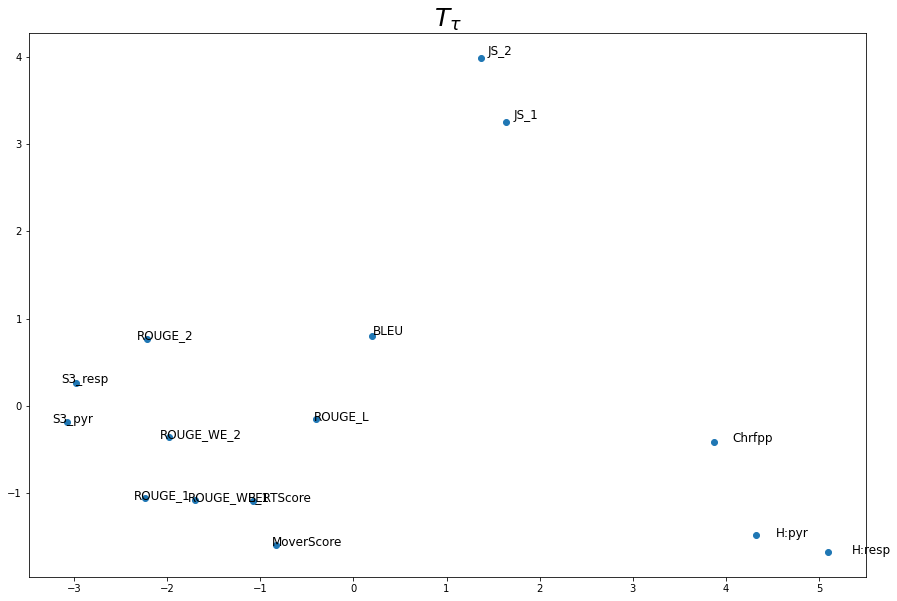

128.29766408182655 before
111.37794824075382 adfter
Starting with 15 nodes.
Aggregation 1 completed with 2 clusters and  0.0958767905831337 increment.
Aggregation 2 completed with 2 clusters and  0.0 increment.
$S_\tau$
-0.7499134357129393
-0.49420337488699334
4.196418705858026
6.81945418690124
8.243949717399346
-1.1290257579328702
-1.9903119918313377
-0.7496695321611715
-1.8349787514240015
-2.3518784954459044
-1.7813264327908094
-1.8279810635622862
-1.5713925196102756
-2.3617537429398467
-2.4173875118601735


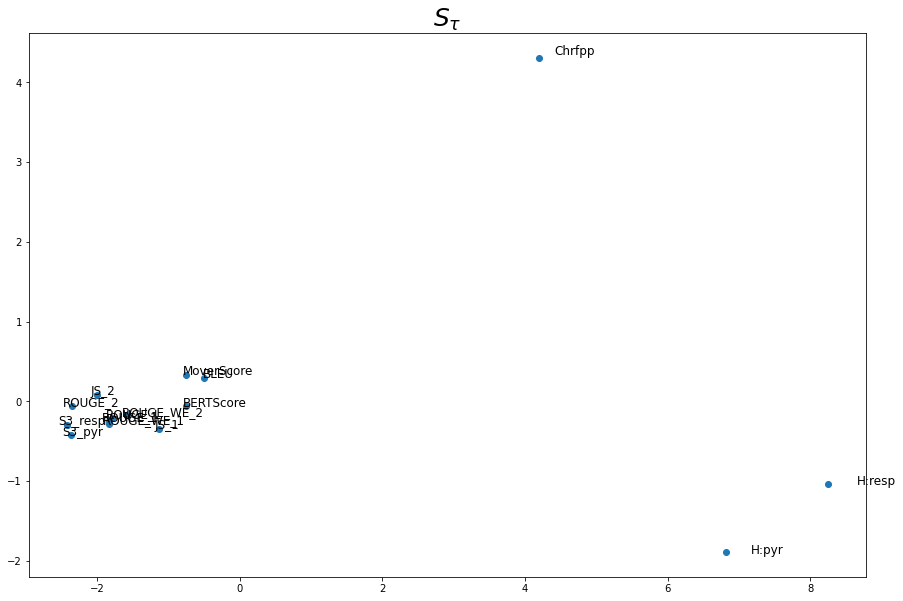

114.2960123603413 before
96.00422832980972 adfter
Starting with 15 nodes.
Aggregation 1 completed with 5 clusters and  0.058550652116537094 increment.
Aggregation 2 completed with 4 clusters and  0.025156602263450623 increment.
Aggregation 3 completed with 4 clusters and  0.0 increment.
$T_\tau$
-1.0781210944560495
0.20354960612677322
3.876907204870039
4.325115132409978
5.095877202983105
1.6364739758048519
1.3707360993354734
-0.8345769679585763
-2.242909982599998
-2.2190167822302236
-0.3993059919183647
-1.696901585295363
-1.9782511439538342
-3.0760356898845758
-2.983539983233234


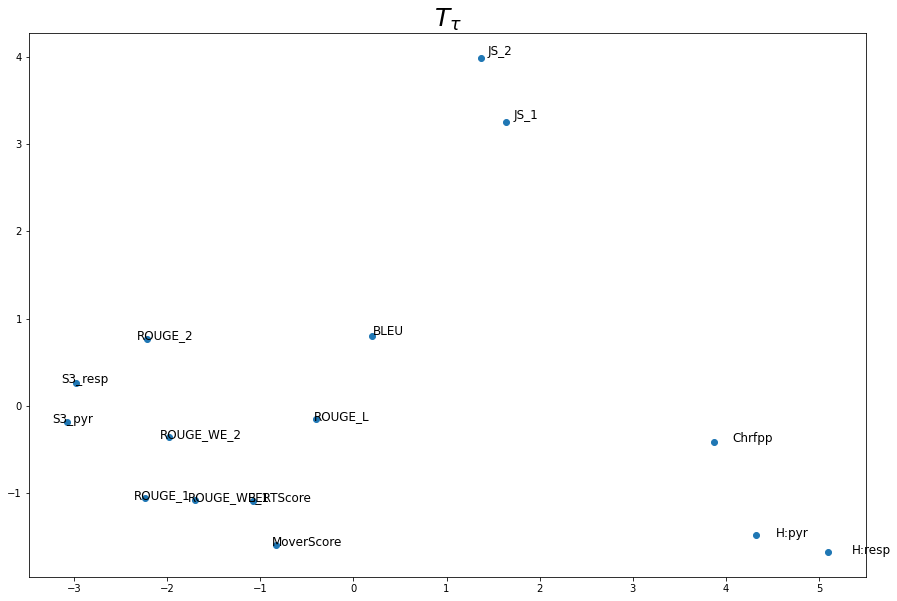

128.29766408182655 before
Starting with 15 nodes.
Aggregation 1 completed with 2 clusters and  0.06345419585704803 increment.
$S_\tau$
-0.7499134357129393
-0.49420337488699334
4.196418705858026
6.81945418690124
8.243949717399346
-1.1290257579328702
-1.9903119918313377
-0.7496695321611715
-1.8349787514240015
-2.3518784954459044
-1.7813264327908094
-1.8279810635622862
-1.5713925196102756
-2.3617537429398467
-2.4173875118601735


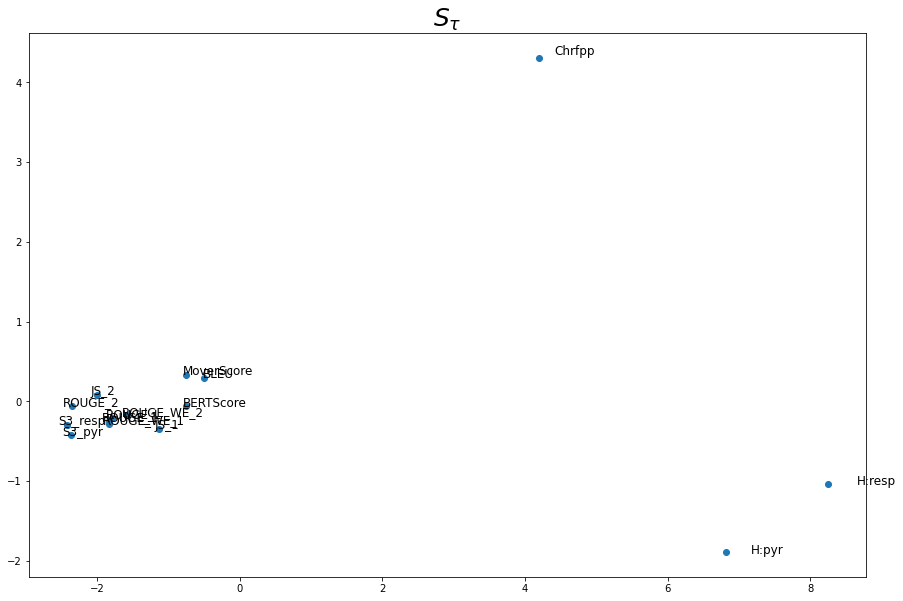

114.2960123603413 before
Starting with 15 nodes.
Aggregation 1 completed with 2 clusters and  0.0828285738825798 increment.
Aggregation 2 completed with 2 clusters and  0.0 increment.


In [48]:
### SAVING EVERYTHING

tol = 0.0001
verbose = 1
resolution = 1
shuffle_nodes = False
ACTIVATE = False
modularity = 'dugue' # 'dugue', 'newman' or 'potts'

AVAILBLE_DATASETS = ['SUM_EVAL.csv','DIALOG_pc.csv','DIALOG_tc.csv','FLICKR.csv','MLQE.csv','REAL_SUM.csv',
                     'SUM_EVAL.csv','TAC_08.csv','TAC_09.csv','TAC_11.csv']
data_path = 'final_df'
for ds_to_load in tqdm(AVAILBLE_DATASETS,'ds'):
    final_dic = {
        'metric_a':[],
        'metric_b':[],
        '$T_p$':[],
    '$T_\\rho$':[],
    '$T_\\tau$':[],
    '$S_\\rho$':[],
    '$S_p$':[],
    '$S_\\tau$':[],
    }
    considered_df = pd.read_csv(os.path.join(data_path,ds_to_load)).set_index(['System','Utterance'])
    for metrics_a in considered_df.columns : 
        for metrics_b in considered_df.columns : 
            results = compute_correlation(considered_df,metrics_a,metrics_b)
            for k,v in results.items():
                if not isinstance(v, float):
                    v = 0
                final_dic[k].append(abs(v))
            final_dic['metric_a'].append(metrics_a)
            final_dic['metric_b'].append(metrics_b)

    count = 0
    for ACTIVATE in [True,False]:
        for k,v in final_dic.items():
            m = len(considered_df.columns)
            if 'metric' not in k:
                if "tau" in k:
                    print(k)
                    
                    df_results = pd.DataFrame(final_dic)
                    df_results = df_results.pivot("metric_a", "metric_b",k)

                    results_mds = plot_pca(df_results,k)
                    try :
                        adjacency = copy.deepcopy(df_results.values)
                        value_to_f = adjacency[0][0]
                        adjacency[adjacency == value_to_f] = 0
                        adjacency_back = copy.deepcopy(adjacency)
                        
                        print(sum(sum(adjacency)),'before')
                        if ACTIVATE :
                            
                            adjacency[adjacency < 0.5] = 0
                            print(sum(sum(adjacency)),'adfter')
                        position = results_mds
                        adjacency = sparse.csr_matrix(adjacency)

                        louvain = Louvain(resolution=resolution,tol_optimization =tol ,
                                          tol_aggregation=tol,shuffle_nodes=shuffle_nodes,verbose=verbose)
                        labels = louvain.fit_transform(adjacency)
                        image = svg_graph( sparse.csr_matrix(adjacency_back), position, labels=labels,
                                          names=df_results.columns, height=400, width=800,node_size= 25,
                              display_node_weight=False, display_edges=True,node_width=4,
                              edge_width_max=10,edge_width_min=1,edge_color='lightgrey',font_size=20,filename= 'example')

                        drawing = svg2rlg("example.svg")
                        renderPDF.drawToFile(drawing, "{}{}{}.pdf".format(
                            ds_to_load.replace('.csv',''),k.replace('$','').replace(
                                '_','').replace('\\',''),ACTIVATE))
                        SVG(image)
                    except: 
                        print("Error",adjacency)










In [44]:
adjacency.todense()

matrix([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [42]:
results_mds

array([[0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.]])

In [38]:
np.array(copy.deepcopy(df_results.values))

(19, 19)

In [26]:
def plot_pca(df_results,k):
    pca = PCA(n_components=2)
    scaler = StandardScaler()
    results = pca.fit_transform(scaler.fit_transform(np.transpose(1-df_results.values)))
    plt.figure(figsize=(15,10))
    plt.scatter(results[:,0], results[:,1])
    for i, txt in enumerate(df_results.columns):
        print(results[i,0])
        plt.annotate(txt, (results[i,0]*1.05, results[i,1]*1.01), fontsize=12)
    plt.title(k,fontsize=25)
    plt.show()
    plt.close()
    return results